In [1]:
import pandas as pd 
import numpy as np 
from scipy.stats import entropy
import matplotlib.pyplot as plt

from engine_hms_trainer import *
from engine_hms_model import CustomModel, JobConfig, ModelConfig

import torch
from torch import nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
seed_everything(JobConfig.SEED)

ModelConfig.EPOCHS = 6
ModelConfig.MODEL_BACKBONE = 'tf_efficientnet_b2'
ModelConfig.MODEL_NAME = "ENet_b2_softmax"
ModelConfig.AUGMENT = True
ModelConfig.USE_KAGGLE_SPECTROGRAMS = True
ModelConfig.USE_EEG_SPECTROGRAMS = True
ModelConfig.REGULARIZATION = None
ModelConfig.AUGMENTATIONS = ['xy_masking']

hms_predictor = HMSPredictor(JobConfig, ModelConfig)

****************************************************************************************************
Script Start: Tue Mar 12 00:27:04 2024
Initializing HMS Predictor...
Model Name: ENet_b2_softmax
Drop Rate: 0.15
Drop Path Rate: 0.25
Augment: True
Augmentations: ['xy_masking']
Enropy Split: 5.5
Device: cuda
Output Dir: ./outputs/
****************************************************************************************************


In [3]:
train_easy, train_hard, all_specs, all_eegs = hms_predictor.load_train_data()

print(train_easy.shape)
print(train_hard.shape)

# check if contain NaN
print(train_easy.isnull().sum().sum())
print(train_hard.isnull().sum().sum())

display(train_easy.head())
print(" ")
display(train_hard.head())

(13996, 12)
(6187, 12)
0
0


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,642382,0.0,0.0,0.0,0.0,0.0,1.0,14960202,1008.0,1032.0,5955,Other
1,751790,0.0,0.0,1.0,0.0,0.0,0.0,618728447,908.0,908.0,38549,GPD
2,778705,0.0,0.0,0.0,0.0,0.0,1.0,52296320,0.0,0.0,40955,Other
3,1629671,1.0,0.0,0.0,0.0,0.0,0.0,2036345030,0.0,160.0,37481,Seizure
4,2061593,0.0,0.0,0.0,0.0,0.0,1.0,320962633,1450.0,1450.0,23828,Other


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,568657,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,789577333,0.0,16.0,20654,Other
1,582999,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,1552638400,0.0,38.0,20230,LPD
2,1895581,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,128369999,1138.0,1138.0,47999,Other
3,2482631,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,20606,Other
4,2521897,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,62117,Other


In [4]:
hms_predictor.train_folds(train_easy, train_hard, all_specs, all_eegs)

Fold: 0 || Valid size 6867 
- First Stage 


Train:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch: [1][0/566]Elapsed 1.08s | Loss: 0.8913 Grad: 82335.9375 LR: 4.0000e-06
Epoch: [1][50/566]Elapsed 8.26s | Loss: 0.8351 Grad: 89566.4062 LR: 5.2855e-06
Epoch: [1][100/566]Elapsed 15.37s | Loss: 0.8311 Grad: 66099.8438 LR: 9.0731e-06
Epoch: [1][150/566]Elapsed 22.49s | Loss: 0.8228 Grad: 66461.1172 LR: 1.5160e-05
Epoch: [1][200/566]Elapsed 29.64s | Loss: 0.8144 Grad: 66164.1562 LR: 2.3220e-05
Epoch: [1][250/566]Elapsed 36.84s | Loss: 0.8011 Grad: 84473.6641 LR: 3.2822e-05
Epoch: [1][300/566]Elapsed 44.01s | Loss: 0.7835 Grad: 82215.5156 LR: 4.3451e-05
Epoch: [1][350/566]Elapsed 51.23s | Loss: 0.7649 Grad: 126950.2734 LR: 5.4537e-05
Epoch: [1][400/566]Elapsed 58.45s | Loss: 0.7442 Grad: 83707.9219 LR: 6.5488e-05
Epoch: [1][450/566]Elapsed 65.68s | Loss: 0.7274 Grad: 65775.3047 LR: 7.5717e-05
Epoch: [1][500/566]Elapsed 72.90s | Loss: 0.7098 Grad: 46049.0469 LR: 8.4675e-05
Epoch: [1][550/566]Elapsed 80.14s | Loss: 0.6924 Grad: 79884.2500 LR: 9.1883e-05
Epoch: [1][565/566]Elapsed 82.38

Valid:   0%|          | 0/430 [00:00<?, ?batch/s]

Epoch: [1][0/430]Elapsed 0.10s | Loss: 0.5094
Epoch: [1][50/430]Elapsed 4.91s | Loss: 0.4667
Epoch: [1][100/430]Elapsed 9.73s | Loss: 0.4697
Epoch: [1][150/430]Elapsed 14.56s | Loss: 0.4741
Epoch: [1][200/430]Elapsed 19.40s | Loss: 0.4835
Epoch: [1][250/430]Elapsed 24.23s | Loss: 0.4873
Epoch: [1][300/430]Elapsed 29.07s | Loss: 0.4904
Epoch: [1][350/430]Elapsed 33.91s | Loss: 0.4694
Epoch: [1][400/430]Elapsed 38.75s | Loss: 0.4566


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Train Loss: 0.6882 | Average Valid Loss: 0.4502 | Time: 124.09s
Best model found in epoch 1 | valid loss: 0.4502


Train:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch: [2][0/566]Elapsed 0.10s | Loss: 0.6063 Grad: 151282.5469 LR: 9.3754e-05
Epoch: [2][50/566]Elapsed 7.44s | Loss: 0.4830 Grad: 64462.5391 LR: 9.8078e-05
Epoch: [2][100/566]Elapsed 14.87s | Loss: 0.4808 Grad: 32324.8516 LR: 9.9935e-05
Epoch: [2][150/566]Elapsed 22.30s | Loss: 0.4708 Grad: 43021.0000 LR: 9.9990e-05
Epoch: [2][200/566]Elapsed 29.73s | Loss: 0.4579 Grad: 23893.7305 LR: 9.9948e-05
Epoch: [2][250/566]Elapsed 37.13s | Loss: 0.4513 Grad: 44021.8477 LR: 9.9873e-05
Epoch: [2][300/566]Elapsed 44.50s | Loss: 0.4436 Grad: 28781.0312 LR: 9.9765e-05
Epoch: [2][350/566]Elapsed 51.85s | Loss: 0.4378 Grad: 36214.8945 LR: 9.9624e-05
Epoch: [2][400/566]Elapsed 59.22s | Loss: 0.4318 Grad: 23733.2129 LR: 9.9450e-05
Epoch: [2][450/566]Elapsed 66.58s | Loss: 0.4290 Grad: 51727.7188 LR: 9.9244e-05
Epoch: [2][500/566]Elapsed 73.92s | Loss: 0.4245 Grad: 43724.2930 LR: 9.9006e-05
Epoch: [2][550/566]Elapsed 81.29s | Loss: 0.4197 Grad: 38395.3438 LR: 9.8734e-05
Epoch: [2][565/566]Elapsed 83.56

Valid:   0%|          | 0/430 [00:00<?, ?batch/s]

Epoch: [2][0/430]Elapsed 0.10s | Loss: 0.3813
Epoch: [2][50/430]Elapsed 4.91s | Loss: 0.3417
Epoch: [2][100/430]Elapsed 9.71s | Loss: 0.3394
Epoch: [2][150/430]Elapsed 14.52s | Loss: 0.3469
Epoch: [2][200/430]Elapsed 19.33s | Loss: 0.3580
Epoch: [2][250/430]Elapsed 24.14s | Loss: 0.3632
Epoch: [2][300/430]Elapsed 28.97s | Loss: 0.3656
Epoch: [2][350/430]Elapsed 33.80s | Loss: 0.3584
Epoch: [2][400/430]Elapsed 38.64s | Loss: 0.3529


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Train Loss: 0.4197 | Average Valid Loss: 0.3505 | Time: 125.13s
Best model found in epoch 2 | valid loss: 0.3505


Train:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch: [3][0/566]Elapsed 0.10s | Loss: 0.3596 Grad: 157310.9062 LR: 9.8641e-05
Epoch: [3][50/566]Elapsed 7.49s | Loss: 0.3618 Grad: 68617.8672 LR: 9.8327e-05
Epoch: [3][100/566]Elapsed 14.94s | Loss: 0.3618 Grad: 65525.3867 LR: 9.7982e-05
Epoch: [3][150/566]Elapsed 22.37s | Loss: 0.3579 Grad: 87869.8906 LR: 9.7605e-05
Epoch: [3][200/566]Elapsed 29.80s | Loss: 0.3490 Grad: 23252.5586 LR: 9.7197e-05
Epoch: [3][250/566]Elapsed 37.21s | Loss: 0.3474 Grad: 43197.0742 LR: 9.6757e-05
Epoch: [3][300/566]Elapsed 44.61s | Loss: 0.3393 Grad: 27452.0098 LR: 9.6286e-05
Epoch: [3][350/566]Elapsed 52.00s | Loss: 0.3366 Grad: 45454.8516 LR: 9.5785e-05
Epoch: [3][400/566]Elapsed 59.37s | Loss: 0.3348 Grad: 44996.8750 LR: 9.5254e-05
Epoch: [3][450/566]Elapsed 66.74s | Loss: 0.3349 Grad: 46607.2930 LR: 9.4693e-05
Epoch: [3][500/566]Elapsed 74.10s | Loss: 0.3320 Grad: 39195.6133 LR: 9.4102e-05
Epoch: [3][550/566]Elapsed 81.46s | Loss: 0.3298 Grad: 52473.4453 LR: 9.3483e-05
Epoch: [3][565/566]Elapsed 83.74

Valid:   0%|          | 0/430 [00:00<?, ?batch/s]

Epoch: [3][0/430]Elapsed 0.10s | Loss: 0.3239
Epoch: [3][50/430]Elapsed 4.89s | Loss: 0.3300
Epoch: [3][100/430]Elapsed 9.68s | Loss: 0.3200
Epoch: [3][150/430]Elapsed 14.48s | Loss: 0.3289
Epoch: [3][200/430]Elapsed 19.28s | Loss: 0.3384
Epoch: [3][250/430]Elapsed 24.09s | Loss: 0.3420
Epoch: [3][300/430]Elapsed 28.92s | Loss: 0.3450
Epoch: [3][350/430]Elapsed 33.74s | Loss: 0.3449
Epoch: [3][400/430]Elapsed 38.56s | Loss: 0.3453


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Train Loss: 0.3304 | Average Valid Loss: 0.3460 | Time: 125.23s
Best model found in epoch 3 | valid loss: 0.3460


Train:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch: [4][0/566]Elapsed 0.10s | Loss: 0.3315 Grad: 164238.5938 LR: 9.3278e-05
Epoch: [4][50/566]Elapsed 7.51s | Loss: 0.3182 Grad: 35668.6602 LR: 9.2621e-05
Epoch: [4][100/566]Elapsed 14.98s | Loss: 0.3128 Grad: 38008.3281 LR: 9.1935e-05
Epoch: [4][150/566]Elapsed 22.44s | Loss: 0.3065 Grad: 43127.7695 LR: 9.1222e-05
Epoch: [4][200/566]Elapsed 29.87s | Loss: 0.3006 Grad: 34148.3477 LR: 9.0481e-05
Epoch: [4][250/566]Elapsed 37.27s | Loss: 0.2969 Grad: 49629.0430 LR: 8.9714e-05
Epoch: [4][300/566]Elapsed 44.68s | Loss: 0.2900 Grad: 25426.4355 LR: 8.8921e-05
Epoch: [4][350/566]Elapsed 52.08s | Loss: 0.2869 Grad: 47233.3945 LR: 8.8101e-05
Epoch: [4][400/566]Elapsed 59.46s | Loss: 0.2839 Grad: 42342.5703 LR: 8.7257e-05
Epoch: [4][450/566]Elapsed 66.83s | Loss: 0.2835 Grad: 36267.5234 LR: 8.6388e-05
Epoch: [4][500/566]Elapsed 74.19s | Loss: 0.2813 Grad: 49990.8320 LR: 8.5495e-05
Epoch: [4][550/566]Elapsed 81.56s | Loss: 0.2791 Grad: 27511.8711 LR: 8.4579e-05
Epoch: [4][565/566]Elapsed 83.84

Valid:   0%|          | 0/430 [00:00<?, ?batch/s]

Epoch: [4][0/430]Elapsed 0.10s | Loss: 0.3143
Epoch: [4][50/430]Elapsed 4.89s | Loss: 0.3161
Epoch: [4][100/430]Elapsed 9.68s | Loss: 0.3041
Epoch: [4][150/430]Elapsed 14.49s | Loss: 0.3121
Epoch: [4][200/430]Elapsed 19.30s | Loss: 0.3196
Epoch: [4][250/430]Elapsed 24.10s | Loss: 0.3219
Epoch: [4][300/430]Elapsed 28.92s | Loss: 0.3238
Epoch: [4][350/430]Elapsed 33.74s | Loss: 0.3281
Epoch: [4][400/430]Elapsed 38.57s | Loss: 0.3323


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Train Loss: 0.2793 | Average Valid Loss: 0.3350 | Time: 125.32s
Best model found in epoch 4 | valid loss: 0.3350


Train:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch: [5][0/566]Elapsed 0.10s | Loss: 0.2529 Grad: nan LR: 8.4281e-05
Epoch: [5][50/566]Elapsed 7.54s | Loss: 0.2649 Grad: 37201.7148 LR: 8.3335e-05
Epoch: [5][100/566]Elapsed 15.03s | Loss: 0.2570 Grad: 33205.7344 LR: 8.2366e-05
Epoch: [5][150/566]Elapsed 22.50s | Loss: 0.2545 Grad: 80655.9141 LR: 8.1377e-05
Epoch: [5][200/566]Elapsed 29.96s | Loss: 0.2493 Grad: 25770.5996 LR: 8.0366e-05
Epoch: [5][250/566]Elapsed 37.41s | Loss: 0.2487 Grad: 34441.9805 LR: 7.9336e-05
Epoch: [5][300/566]Elapsed 44.85s | Loss: 0.2422 Grad: 23901.8262 LR: 7.8286e-05
Epoch: [5][350/566]Elapsed 52.27s | Loss: 0.2381 Grad: 57933.0234 LR: 7.7218e-05
Epoch: [5][400/566]Elapsed 59.66s | Loss: 0.2348 Grad: 56164.4141 LR: 7.6131e-05
Epoch: [5][450/566]Elapsed 67.05s | Loss: 0.2351 Grad: 50615.3672 LR: 7.5028e-05
Epoch: [5][500/566]Elapsed 74.41s | Loss: 0.2320 Grad: 43271.2578 LR: 7.3908e-05
Epoch: [5][550/566]Elapsed 81.79s | Loss: 0.2312 Grad: 68364.3125 LR: 7.2772e-05
Epoch: [5][565/566]Elapsed 84.08s | Loss

Valid:   0%|          | 0/430 [00:00<?, ?batch/s]

Epoch: [5][0/430]Elapsed 0.10s | Loss: 0.2885
Epoch: [5][50/430]Elapsed 4.89s | Loss: 0.3257
Epoch: [5][100/430]Elapsed 9.68s | Loss: 0.3074
Epoch: [5][150/430]Elapsed 14.49s | Loss: 0.3145
Epoch: [5][200/430]Elapsed 19.30s | Loss: 0.3198
Epoch: [5][250/430]Elapsed 24.12s | Loss: 0.3208
Epoch: [5][300/430]Elapsed 28.93s | Loss: 0.3215
Epoch: [5][350/430]Elapsed 33.76s | Loss: 0.3325
Epoch: [5][400/430]Elapsed 38.59s | Loss: 0.3424


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Train Loss: 0.2314 | Average Valid Loss: 0.3482 | Time: 125.59s


Train:   0%|          | 0/566 [00:00<?, ?batch/s]

Epoch: [6][0/566]Elapsed 0.10s | Loss: 0.2989 Grad: nan LR: 7.2405e-05
Epoch: [6][50/566]Elapsed 7.52s | Loss: 0.2354 Grad: 52157.2617 LR: 7.1249e-05
Epoch: [6][100/566]Elapsed 14.98s | Loss: 0.2258 Grad: 32308.8633 LR: 7.0080e-05
Epoch: [6][150/566]Elapsed 22.41s | Loss: 0.2197 Grad: 47915.2969 LR: 6.8897e-05
Epoch: [6][200/566]Elapsed 29.84s | Loss: 0.2161 Grad: 57871.3555 LR: 6.7702e-05
Epoch: [6][250/566]Elapsed 37.24s | Loss: 0.2136 Grad: 65771.9844 LR: 6.6495e-05
Epoch: [6][300/566]Elapsed 44.64s | Loss: 0.2102 Grad: 34740.7500 LR: 6.5277e-05
Epoch: [6][350/566]Elapsed 52.04s | Loss: 0.2062 Grad: 45309.0938 LR: 6.4049e-05
Epoch: [6][400/566]Elapsed 59.43s | Loss: 0.2034 Grad: 56066.4688 LR: 6.2812e-05
Epoch: [6][450/566]Elapsed 66.81s | Loss: 0.2031 Grad: 50089.8398 LR: 6.1566e-05
Epoch: [6][500/566]Elapsed 74.20s | Loss: 0.2006 Grad: 55623.7422 LR: 6.0313e-05
Epoch: [6][550/566]Elapsed 81.57s | Loss: 0.1999 Grad: 39691.4727 LR: 5.9053e-05
Epoch: [6][565/566]Elapsed 83.84s | Loss

Valid:   0%|          | 0/430 [00:00<?, ?batch/s]

Epoch: [6][0/430]Elapsed 0.10s | Loss: 0.2968
Epoch: [6][50/430]Elapsed 4.89s | Loss: 0.3256
Epoch: [6][100/430]Elapsed 9.68s | Loss: 0.3094
Epoch: [6][150/430]Elapsed 14.47s | Loss: 0.3207
Epoch: [6][200/430]Elapsed 19.28s | Loss: 0.3221
Epoch: [6][250/430]Elapsed 24.09s | Loss: 0.3209
Epoch: [6][300/430]Elapsed 28.92s | Loss: 0.3217
Epoch: [6][350/430]Elapsed 33.74s | Loss: 0.3357
Epoch: [6][400/430]Elapsed 38.57s | Loss: 0.3479


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Train Loss: 0.1997 | Average Valid Loss: 0.3558 | Time: 125.34s
Fold 0 Valid Loss: (Easy) 1.2257 | (Hard) 0.7583
Elapse: 12.53 min 
- Second Stage 
Use Checkpoint: ENet_b2_softmax_fold_0_stage_1.pth


Train:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch: [1][0/265]Elapsed 0.10s | Loss: 0.3945 Grad: nan LR: 4.0000e-06
Epoch: [1][50/265]Elapsed 7.45s | Loss: 0.4674 Grad: 48771.8594 LR: 9.8092e-06
Epoch: [1][100/265]Elapsed 14.89s | Loss: 0.4363 Grad: 54715.4297 LR: 2.5831e-05
Epoch: [1][150/265]Elapsed 22.32s | Loss: 0.4046 Grad: 50625.6680 LR: 4.8186e-05
Epoch: [1][200/265]Elapsed 29.74s | Loss: 0.3736 Grad: 25776.2188 LR: 7.1465e-05
Epoch: [1][250/265]Elapsed 37.16s | Loss: 0.3487 Grad: 30632.9434 LR: 9.0032e-05
Epoch: [1][264/265]Elapsed 39.25s | Loss: 0.3417 Grad: 24517.6035 LR: 9.3727e-05


Valid:   0%|          | 0/430 [00:00<?, ?batch/s]

Epoch: [1][0/430]Elapsed 0.10s | Loss: 0.3227
Epoch: [1][50/430]Elapsed 4.89s | Loss: 0.3861
Epoch: [1][100/430]Elapsed 9.68s | Loss: 0.3778
Epoch: [1][150/430]Elapsed 14.48s | Loss: 0.3831
Epoch: [1][200/430]Elapsed 19.29s | Loss: 0.3737
Epoch: [1][250/430]Elapsed 24.10s | Loss: 0.3696
Epoch: [1][300/430]Elapsed 28.91s | Loss: 0.3662
Epoch: [1][350/430]Elapsed 33.71s | Loss: 0.3492
Epoch: [1][400/430]Elapsed 38.53s | Loss: 0.3334


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Train Loss: 0.3417 | Average Valid Loss: 0.3257 | Time: 80.76s
Best model found in epoch 1 | valid loss: 0.3257


Train:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch: [2][0/265]Elapsed 0.10s | Loss: 0.1874 Grad: 104293.8828 LR: 9.3727e-05
Epoch: [2][50/265]Elapsed 7.58s | Loss: 0.2216 Grad: 58832.2930 LR: 9.9991e-05
Epoch: [2][100/265]Elapsed 15.09s | Loss: 0.2228 Grad: 44881.9062 LR: 9.9931e-05
Epoch: [2][150/265]Elapsed 22.59s | Loss: 0.2225 Grad: 59647.8945 LR: 9.9711e-05
Epoch: [2][200/265]Elapsed 30.05s | Loss: 0.2204 Grad: 54149.3242 LR: 9.9342e-05
Epoch: [2][250/265]Elapsed 37.50s | Loss: 0.2162 Grad: 41220.6836 LR: 9.8824e-05
Epoch: [2][264/265]Elapsed 39.60s | Loss: 0.2151 Grad: 43226.6094 LR: 9.8653e-05


Valid:   0%|          | 0/430 [00:00<?, ?batch/s]

Epoch: [2][0/430]Elapsed 0.10s | Loss: 0.3323
Epoch: [2][50/430]Elapsed 4.90s | Loss: 0.3811
Epoch: [2][100/430]Elapsed 9.69s | Loss: 0.3760
Epoch: [2][150/430]Elapsed 14.49s | Loss: 0.3803
Epoch: [2][200/430]Elapsed 19.30s | Loss: 0.3733
Epoch: [2][250/430]Elapsed 24.12s | Loss: 0.3696
Epoch: [2][300/430]Elapsed 28.93s | Loss: 0.3664
Epoch: [2][350/430]Elapsed 33.74s | Loss: 0.3467
Epoch: [2][400/430]Elapsed 38.55s | Loss: 0.3287


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Train Loss: 0.2151 | Average Valid Loss: 0.3201 | Time: 81.10s
Best model found in epoch 2 | valid loss: 0.3201


Train:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch: [3][0/265]Elapsed 0.10s | Loss: 0.1708 Grad: 98020.0938 LR: 9.8653e-05
Epoch: [3][50/265]Elapsed 7.60s | Loss: 0.1934 Grad: 81771.1641 LR: 9.7947e-05
Epoch: [3][100/265]Elapsed 15.13s | Loss: 0.1937 Grad: 39989.6133 LR: 9.7097e-05
Epoch: [3][150/265]Elapsed 22.62s | Loss: 0.1940 Grad: 52781.4844 LR: 9.6106e-05
Epoch: [3][200/265]Elapsed 30.10s | Loss: 0.1937 Grad: 36180.5586 LR: 9.4975e-05
Epoch: [3][250/265]Elapsed 37.53s | Loss: 0.1910 Grad: 35075.8281 LR: 9.3710e-05
Epoch: [3][264/265]Elapsed 39.62s | Loss: 0.1899 Grad: 43564.4492 LR: 9.3331e-05


Valid:   0%|          | 0/430 [00:00<?, ?batch/s]

Epoch: [3][0/430]Elapsed 0.10s | Loss: 0.3382
Epoch: [3][50/430]Elapsed 4.89s | Loss: 0.3838
Epoch: [3][100/430]Elapsed 9.68s | Loss: 0.3786
Epoch: [3][150/430]Elapsed 14.50s | Loss: 0.3826
Epoch: [3][200/430]Elapsed 19.31s | Loss: 0.3762
Epoch: [3][250/430]Elapsed 24.13s | Loss: 0.3728
Epoch: [3][300/430]Elapsed 28.94s | Loss: 0.3701
Epoch: [3][350/430]Elapsed 33.75s | Loss: 0.3498
Epoch: [3][400/430]Elapsed 38.57s | Loss: 0.3313


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Train Loss: 0.1899 | Average Valid Loss: 0.3223 | Time: 81.17s


Train:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch: [4][0/265]Elapsed 0.10s | Loss: 0.1496 Grad: 87580.9453 LR: 9.3331e-05
Epoch: [4][50/265]Elapsed 7.57s | Loss: 0.1763 Grad: 94908.8359 LR: 9.1898e-05
Epoch: [4][100/265]Elapsed 15.07s | Loss: 0.1762 Grad: 66062.6953 LR: 9.0338e-05
Epoch: [4][150/265]Elapsed 22.53s | Loss: 0.1777 Grad: 108225.5781 LR: 8.8657e-05
Epoch: [4][200/265]Elapsed 29.98s | Loss: 0.1764 Grad: 46900.0000 LR: 8.6860e-05
Epoch: [4][250/265]Elapsed 37.42s | Loss: 0.1744 Grad: 43983.8125 LR: 8.4952e-05
Epoch: [4][264/265]Elapsed 39.51s | Loss: 0.1733 Grad: 38384.8086 LR: 8.4398e-05


Valid:   0%|          | 0/430 [00:00<?, ?batch/s]

Epoch: [4][0/430]Elapsed 0.10s | Loss: 0.3493
Epoch: [4][50/430]Elapsed 4.90s | Loss: 0.3792
Epoch: [4][100/430]Elapsed 9.69s | Loss: 0.3733
Epoch: [4][150/430]Elapsed 14.50s | Loss: 0.3774
Epoch: [4][200/430]Elapsed 19.32s | Loss: 0.3706
Epoch: [4][250/430]Elapsed 24.13s | Loss: 0.3677
Epoch: [4][300/430]Elapsed 28.94s | Loss: 0.3645
Epoch: [4][350/430]Elapsed 33.75s | Loss: 0.3443
Epoch: [4][400/430]Elapsed 38.59s | Loss: 0.3260


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Train Loss: 0.1733 | Average Valid Loss: 0.3174 | Time: 81.07s
Best model found in epoch 4 | valid loss: 0.3174


Train:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch: [5][0/265]Elapsed 0.10s | Loss: 0.1265 Grad: 93969.8906 LR: 8.4398e-05
Epoch: [5][50/265]Elapsed 7.56s | Loss: 0.1558 Grad: 57849.7969 LR: 8.2356e-05
Epoch: [5][100/265]Elapsed 15.06s | Loss: 0.1560 Grad: 68695.8047 LR: 8.0217e-05
Epoch: [5][150/265]Elapsed 22.51s | Loss: 0.1592 Grad: 42124.0391 LR: 7.7987e-05
Epoch: [5][200/265]Elapsed 29.95s | Loss: 0.1592 Grad: 35896.7773 LR: 7.5672e-05
Epoch: [5][250/265]Elapsed 37.37s | Loss: 0.1571 Grad: 40321.9375 LR: 7.3280e-05
Epoch: [5][264/265]Elapsed 39.46s | Loss: 0.1563 Grad: 45408.3047 LR: 7.2598e-05


Valid:   0%|          | 0/430 [00:00<?, ?batch/s]

Epoch: [5][0/430]Elapsed 0.10s | Loss: 0.3426
Epoch: [5][50/430]Elapsed 4.90s | Loss: 0.3873
Epoch: [5][100/430]Elapsed 9.70s | Loss: 0.3821
Epoch: [5][150/430]Elapsed 14.51s | Loss: 0.3860
Epoch: [5][200/430]Elapsed 19.33s | Loss: 0.3776
Epoch: [5][250/430]Elapsed 24.14s | Loss: 0.3743
Epoch: [5][300/430]Elapsed 28.96s | Loss: 0.3708
Epoch: [5][350/430]Elapsed 33.77s | Loss: 0.3501
Epoch: [5][400/430]Elapsed 38.59s | Loss: 0.3310


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Train Loss: 0.1563 | Average Valid Loss: 0.3221 | Time: 81.00s


Train:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch: [6][0/265]Elapsed 0.10s | Loss: 0.1098 Grad: 96570.5547 LR: 7.2598e-05
Epoch: [6][50/265]Elapsed 7.57s | Loss: 0.1480 Grad: 64460.5117 LR: 7.0118e-05
Epoch: [6][100/265]Elapsed 15.08s | Loss: 0.1470 Grad: 44540.9102 LR: 6.7577e-05
Epoch: [6][150/265]Elapsed 22.55s | Loss: 0.1479 Grad: 50012.2148 LR: 6.4984e-05
Epoch: [6][200/265]Elapsed 30.02s | Loss: 0.1472 Grad: 48980.5117 LR: 6.2345e-05
Epoch: [6][250/265]Elapsed 37.51s | Loss: 0.1448 Grad: 35120.7148 LR: 5.9670e-05
Epoch: [6][264/265]Elapsed 39.62s | Loss: 0.1440 Grad: 47404.4648 LR: 5.8915e-05


Valid:   0%|          | 0/430 [00:00<?, ?batch/s]

Epoch: [6][0/430]Elapsed 0.10s | Loss: 0.3555
Epoch: [6][50/430]Elapsed 4.89s | Loss: 0.3842
Epoch: [6][100/430]Elapsed 9.68s | Loss: 0.3786
Epoch: [6][150/430]Elapsed 14.48s | Loss: 0.3824
Epoch: [6][200/430]Elapsed 19.31s | Loss: 0.3745
Epoch: [6][250/430]Elapsed 24.12s | Loss: 0.3716
Epoch: [6][300/430]Elapsed 28.94s | Loss: 0.3680
Epoch: [6][350/430]Elapsed 33.75s | Loss: 0.3476
Epoch: [6][400/430]Elapsed 38.56s | Loss: 0.3289


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Train Loss: 0.1440 | Average Valid Loss: 0.3203 | Time: 81.12s
Fold 0 Valid Loss: (Easy) 1.3068 | (Hard) 0.7462
Elapse: 8.11 min 
Fold: 1 || Valid size 4196 
- First Stage 


Train:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch: [1][0/688]Elapsed 0.10s | Loss: 0.8406 Grad: 74531.7266 LR: 4.0000e-06
Epoch: [1][50/688]Elapsed 7.51s | Loss: 0.8189 Grad: 70712.8047 LR: 4.8704e-06
Epoch: [1][100/688]Elapsed 15.03s | Loss: 0.8164 Grad: 72728.4453 LR: 7.4499e-06
Epoch: [1][150/688]Elapsed 22.52s | Loss: 0.8064 Grad: 54411.1055 LR: 1.1645e-05
Epoch: [1][200/688]Elapsed 29.98s | Loss: 0.7997 Grad: 80660.9766 LR: 1.7304e-05
Epoch: [1][250/688]Elapsed 37.42s | Loss: 0.7930 Grad: 74737.5938 LR: 2.4221e-05
Epoch: [1][300/688]Elapsed 44.88s | Loss: 0.7835 Grad: 83652.4531 LR: 3.2145e-05
Epoch: [1][350/688]Elapsed 52.31s | Loss: 0.7703 Grad: 81831.9453 LR: 4.0789e-05
Epoch: [1][400/688]Elapsed 59.73s | Loss: 0.7554 Grad: 97862.4453 LR: 4.9840e-05
Epoch: [1][450/688]Elapsed 67.13s | Loss: 0.7401 Grad: 82845.8984 LR: 5.8969e-05
Epoch: [1][500/688]Elapsed 74.53s | Loss: 0.7251 Grad: 66698.5781 LR: 6.7846e-05
Epoch: [1][550/688]Elapsed 81.91s | Loss: 0.7114 Grad: 55430.0234 LR: 7.6148e-05
Epoch: [1][600/688]Elapsed 89.29s

Valid:   0%|          | 0/263 [00:00<?, ?batch/s]

Epoch: [1][0/263]Elapsed 0.10s | Loss: 0.5842
Epoch: [1][50/263]Elapsed 4.91s | Loss: 0.4523
Epoch: [1][100/263]Elapsed 9.69s | Loss: 0.4495
Epoch: [1][150/263]Elapsed 14.49s | Loss: 0.4400
Epoch: [1][200/263]Elapsed 19.30s | Loss: 0.4215
Epoch: [1][250/263]Elapsed 24.12s | Loss: 0.4004


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Train Loss: 0.6716 | Average Valid Loss: 0.3983 | Time: 127.64s
Best model found in epoch 1 | valid loss: 0.3983


Train:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch: [2][0/688]Elapsed 0.10s | Loss: 0.5052 Grad: 130737.2656 LR: 9.3721e-05
Epoch: [2][50/688]Elapsed 7.47s | Loss: 0.4616 Grad: 109811.2500 LR: 9.7464e-05
Epoch: [2][100/688]Elapsed 14.91s | Loss: 0.4575 Grad: 112770.5859 LR: 9.9558e-05
Epoch: [2][150/688]Elapsed 22.36s | Loss: 0.4535 Grad: 39551.0742 LR: 9.9999e-05
Epoch: [2][200/688]Elapsed 29.77s | Loss: 0.4502 Grad: 42857.2109 LR: 9.9981e-05
Epoch: [2][250/688]Elapsed 37.18s | Loss: 0.4391 Grad: 54987.8945 LR: 9.9942e-05
Epoch: [2][300/688]Elapsed 44.57s | Loss: 0.4364 Grad: 47460.8750 LR: 9.9879e-05
Epoch: [2][350/688]Elapsed 51.96s | Loss: 0.4306 Grad: 33226.6758 LR: 9.9795e-05
Epoch: [2][400/688]Elapsed 59.34s | Loss: 0.4255 Grad: 36875.5195 LR: 9.9688e-05
Epoch: [2][450/688]Elapsed 66.72s | Loss: 0.4210 Grad: 23142.6602 LR: 9.9559e-05
Epoch: [2][500/688]Elapsed 74.09s | Loss: 0.4169 Grad: 43178.3398 LR: 9.9408e-05
Epoch: [2][550/688]Elapsed 81.45s | Loss: 0.4152 Grad: 59953.7461 LR: 9.9235e-05
Epoch: [2][600/688]Elapsed 88.

Valid:   0%|          | 0/263 [00:00<?, ?batch/s]

Epoch: [2][0/263]Elapsed 0.10s | Loss: 0.3681
Epoch: [2][50/263]Elapsed 4.89s | Loss: 0.3551
Epoch: [2][100/263]Elapsed 9.68s | Loss: 0.3539
Epoch: [2][150/263]Elapsed 14.48s | Loss: 0.3410
Epoch: [2][200/263]Elapsed 19.28s | Loss: 0.3344
Epoch: [2][250/263]Elapsed 24.08s | Loss: 0.3267


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Train Loss: 0.4054 | Average Valid Loss: 0.3271 | Time: 127.05s
Best model found in epoch 2 | valid loss: 0.3271


Train:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch: [3][0/688]Elapsed 0.10s | Loss: 0.3479 Grad: inf LR: 9.8643e-05
Epoch: [3][50/688]Elapsed 7.44s | Loss: 0.3318 Grad: 65168.9570 LR: 9.8388e-05
Epoch: [3][100/688]Elapsed 14.84s | Loss: 0.3336 Grad: 40010.4219 LR: 9.8111e-05
Epoch: [3][150/688]Elapsed 22.25s | Loss: 0.3324 Grad: 39962.8281 LR: 9.7812e-05
Epoch: [3][200/688]Elapsed 29.62s | Loss: 0.3319 Grad: 38123.3516 LR: 9.7492e-05
Epoch: [3][250/688]Elapsed 36.99s | Loss: 0.3269 Grad: 40945.0781 LR: 9.7151e-05
Epoch: [3][300/688]Elapsed 44.38s | Loss: 0.3264 Grad: 37662.4727 LR: 9.6789e-05
Epoch: [3][350/688]Elapsed 51.75s | Loss: 0.3243 Grad: 31962.1289 LR: 9.6406e-05
Epoch: [3][400/688]Elapsed 59.11s | Loss: 0.3235 Grad: 47424.5039 LR: 9.6002e-05
Epoch: [3][450/688]Elapsed 66.48s | Loss: 0.3221 Grad: 40248.9414 LR: 9.5578e-05
Epoch: [3][500/688]Elapsed 73.85s | Loss: 0.3216 Grad: 67533.1172 LR: 9.5133e-05
Epoch: [3][550/688]Elapsed 81.23s | Loss: 0.3224 Grad: 60062.9180 LR: 9.4669e-05
Epoch: [3][600/688]Elapsed 88.57s | Loss

Valid:   0%|          | 0/263 [00:00<?, ?batch/s]

Epoch: [3][0/263]Elapsed 0.10s | Loss: 0.2997
Epoch: [3][50/263]Elapsed 4.89s | Loss: 0.3435
Epoch: [3][100/263]Elapsed 9.67s | Loss: 0.3345
Epoch: [3][150/263]Elapsed 14.47s | Loss: 0.3231
Epoch: [3][200/263]Elapsed 19.27s | Loss: 0.3169
Epoch: [3][250/263]Elapsed 24.06s | Loss: 0.3153


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Train Loss: 0.3181 | Average Valid Loss: 0.3148 | Time: 126.76s
Best model found in epoch 3 | valid loss: 0.3148


Train:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch: [4][0/688]Elapsed 0.10s | Loss: 0.2321 Grad: inf LR: 9.3283e-05
Epoch: [4][50/688]Elapsed 7.45s | Loss: 0.2717 Grad: 24189.2832 LR: 9.2744e-05
Epoch: [4][100/688]Elapsed 14.87s | Loss: 0.2768 Grad: 42063.4688 LR: 9.2186e-05
Epoch: [4][150/688]Elapsed 22.28s | Loss: 0.2749 Grad: 40737.9766 LR: 9.1610e-05
Epoch: [4][200/688]Elapsed 29.67s | Loss: 0.2776 Grad: 24503.3438 LR: 9.1014e-05
Epoch: [4][250/688]Elapsed 37.05s | Loss: 0.2726 Grad: 35992.7422 LR: 9.0401e-05
Epoch: [4][300/688]Elapsed 44.42s | Loss: 0.2741 Grad: 40333.6211 LR: 8.9769e-05
Epoch: [4][350/688]Elapsed 51.80s | Loss: 0.2716 Grad: 28250.0723 LR: 8.9120e-05
Epoch: [4][400/688]Elapsed 59.16s | Loss: 0.2697 Grad: 38805.6523 LR: 8.8453e-05
Epoch: [4][450/688]Elapsed 66.52s | Loss: 0.2691 Grad: 29226.6699 LR: 8.7769e-05
Epoch: [4][500/688]Elapsed 73.88s | Loss: 0.2679 Grad: 51128.7695 LR: 8.7068e-05
Epoch: [4][550/688]Elapsed 81.25s | Loss: 0.2697 Grad: 54394.5273 LR: 8.6351e-05
Epoch: [4][600/688]Elapsed 88.63s | Loss

Valid:   0%|          | 0/263 [00:00<?, ?batch/s]

Epoch: [4][0/263]Elapsed 0.10s | Loss: 0.2374
Epoch: [4][50/263]Elapsed 4.89s | Loss: 0.3398
Epoch: [4][100/263]Elapsed 9.68s | Loss: 0.3332
Epoch: [4][150/263]Elapsed 14.48s | Loss: 0.3219
Epoch: [4][200/263]Elapsed 19.29s | Loss: 0.3171
Epoch: [4][250/263]Elapsed 24.08s | Loss: 0.3215


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Train Loss: 0.2667 | Average Valid Loss: 0.3225 | Time: 126.89s


Train:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch: [5][0/688]Elapsed 0.10s | Loss: 0.2473 Grad: inf LR: 8.4288e-05
Epoch: [5][50/688]Elapsed 7.51s | Loss: 0.2431 Grad: 29467.2051 LR: 8.3511e-05
Epoch: [5][100/688]Elapsed 14.95s | Loss: 0.2384 Grad: 47329.5078 LR: 8.2719e-05
Epoch: [5][150/688]Elapsed 22.38s | Loss: 0.2369 Grad: 36409.3477 LR: 8.1913e-05
Epoch: [5][200/688]Elapsed 29.81s | Loss: 0.2357 Grad: 28232.3887 LR: 8.1092e-05
Epoch: [5][250/688]Elapsed 37.21s | Loss: 0.2335 Grad: 62563.2891 LR: 8.0258e-05
Epoch: [5][300/688]Elapsed 44.61s | Loss: 0.2333 Grad: 29941.5059 LR: 7.9410e-05
Epoch: [5][350/688]Elapsed 52.00s | Loss: 0.2303 Grad: 18555.4023 LR: 7.8549e-05
Epoch: [5][400/688]Elapsed 59.40s | Loss: 0.2283 Grad: 42669.3281 LR: 7.7675e-05
Epoch: [5][450/688]Elapsed 66.76s | Loss: 0.2282 Grad: 31571.1094 LR: 7.6789e-05
Epoch: [5][500/688]Elapsed 74.14s | Loss: 0.2280 Grad: 50000.6562 LR: 7.5890e-05
Epoch: [5][550/688]Elapsed 81.50s | Loss: 0.2289 Grad: 81524.3359 LR: 7.4981e-05
Epoch: [5][600/688]Elapsed 88.87s | Loss

Valid:   0%|          | 0/263 [00:00<?, ?batch/s]

Epoch: [5][0/263]Elapsed 0.10s | Loss: 0.1815
Epoch: [5][50/263]Elapsed 4.89s | Loss: 0.3408
Epoch: [5][100/263]Elapsed 9.67s | Loss: 0.3330
Epoch: [5][150/263]Elapsed 14.47s | Loss: 0.3220
Epoch: [5][200/263]Elapsed 19.27s | Loss: 0.3212
Epoch: [5][250/263]Elapsed 24.06s | Loss: 0.3303


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Train Loss: 0.2246 | Average Valid Loss: 0.3322 | Time: 127.06s


Train:   0%|          | 0/688 [00:00<?, ?batch/s]

Epoch: [6][0/688]Elapsed 0.11s | Loss: 0.1914 Grad: inf LR: 7.2413e-05
Epoch: [6][50/688]Elapsed 7.47s | Loss: 0.2036 Grad: 40596.8750 LR: 7.1464e-05
Epoch: [6][100/688]Elapsed 14.89s | Loss: 0.2006 Grad: 29874.7617 LR: 7.0505e-05
Epoch: [6][150/688]Elapsed 22.30s | Loss: 0.1941 Grad: 26758.8672 LR: 6.9536e-05
Epoch: [6][200/688]Elapsed 29.71s | Loss: 0.1950 Grad: 45151.2188 LR: 6.8559e-05
Epoch: [6][250/688]Elapsed 37.10s | Loss: 0.1904 Grad: 32084.9648 LR: 6.7574e-05
Epoch: [6][300/688]Elapsed 44.48s | Loss: 0.1909 Grad: 37906.6797 LR: 6.6581e-05
Epoch: [6][350/688]Elapsed 51.84s | Loss: 0.1879 Grad: 20038.9434 LR: 6.5580e-05
Epoch: [6][400/688]Elapsed 59.21s | Loss: 0.1870 Grad: 32596.9297 LR: 6.4573e-05
Epoch: [6][450/688]Elapsed 66.59s | Loss: 0.1870 Grad: 35736.1719 LR: 6.3559e-05
Epoch: [6][500/688]Elapsed 73.98s | Loss: 0.1866 Grad: 62429.0586 LR: 6.2539e-05
Epoch: [6][550/688]Elapsed 81.37s | Loss: 0.1886 Grad: 49791.7383 LR: 6.1513e-05
Epoch: [6][600/688]Elapsed 88.74s | Loss

Valid:   0%|          | 0/263 [00:00<?, ?batch/s]

Epoch: [6][0/263]Elapsed 0.10s | Loss: 0.1363
Epoch: [6][50/263]Elapsed 4.89s | Loss: 0.3527
Epoch: [6][100/263]Elapsed 9.67s | Loss: 0.3392
Epoch: [6][150/263]Elapsed 14.47s | Loss: 0.3271
Epoch: [6][200/263]Elapsed 19.27s | Loss: 0.3273
Epoch: [6][250/263]Elapsed 24.07s | Loss: 0.3368


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Train Loss: 0.1868 | Average Valid Loss: 0.3384 | Time: 126.98s
Fold 1 Valid Loss: (Easy) 1.2245 | (Hard) 0.7744
Elapse: 12.71 min 
- Second Stage 
Use Checkpoint: ENet_b2_softmax_fold_1_stage_1.pth


Train:   0%|          | 0/310 [00:00<?, ?batch/s]

Epoch: [1][0/310]Elapsed 0.10s | Loss: 0.6365 Grad: nan LR: 4.0000e-06
Epoch: [1][50/310]Elapsed 7.43s | Loss: 0.4429 Grad: 77706.9375 LR: 8.2610e-06
Epoch: [1][100/310]Elapsed 14.87s | Loss: 0.4230 Grad: 83468.4219 LR: 2.0288e-05
Epoch: [1][150/310]Elapsed 22.31s | Loss: 0.3927 Grad: 37790.1992 LR: 3.7945e-05
Epoch: [1][200/310]Elapsed 29.70s | Loss: 0.3656 Grad: 32330.3711 LR: 5.8097e-05
Epoch: [1][250/310]Elapsed 37.12s | Loss: 0.3422 Grad: 35759.5195 LR: 7.7167e-05
Epoch: [1][300/310]Elapsed 44.52s | Loss: 0.3232 Grad: 20875.6484 LR: 9.1768e-05
Epoch: [1][309/310]Elapsed 45.94s | Loss: 0.3200 Grad: 40429.9102 LR: 9.3905e-05


Valid:   0%|          | 0/263 [00:00<?, ?batch/s]

Epoch: [1][0/263]Elapsed 0.10s | Loss: 0.3368
Epoch: [1][50/263]Elapsed 4.90s | Loss: 0.4358
Epoch: [1][100/263]Elapsed 9.70s | Loss: 0.4292
Epoch: [1][150/263]Elapsed 14.52s | Loss: 0.4123
Epoch: [1][200/263]Elapsed 19.34s | Loss: 0.3809
Epoch: [1][250/263]Elapsed 24.14s | Loss: 0.3455


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Train Loss: 0.3200 | Average Valid Loss: 0.3393 | Time: 71.35s
Best model found in epoch 1 | valid loss: 0.3393


Train:   0%|          | 0/310 [00:00<?, ?batch/s]

Epoch: [2][0/310]Elapsed 0.11s | Loss: 0.2758 Grad: 113386.7891 LR: 9.3905e-05
Epoch: [2][50/310]Elapsed 7.51s | Loss: 0.2266 Grad: 85519.6172 LR: 9.9827e-05
Epoch: [2][100/310]Elapsed 14.96s | Loss: 0.2280 Grad: 40952.6016 LR: 9.9965e-05
Epoch: [2][150/310]Elapsed 22.38s | Loss: 0.2223 Grad: 47693.6797 LR: 9.9822e-05
Epoch: [2][200/310]Elapsed 29.77s | Loss: 0.2175 Grad: 38967.9727 LR: 9.9569e-05
Epoch: [2][250/310]Elapsed 37.16s | Loss: 0.2136 Grad: 58909.9961 LR: 9.9208e-05
Epoch: [2][300/310]Elapsed 44.55s | Loss: 0.2102 Grad: 46141.7852 LR: 9.8738e-05
Epoch: [2][309/310]Elapsed 45.94s | Loss: 0.2096 Grad: 55421.6172 LR: 9.8631e-05


Valid:   0%|          | 0/263 [00:00<?, ?batch/s]

Epoch: [2][0/263]Elapsed 0.10s | Loss: 0.3550
Epoch: [2][50/263]Elapsed 4.90s | Loss: 0.4265
Epoch: [2][100/263]Elapsed 9.69s | Loss: 0.4245
Epoch: [2][150/263]Elapsed 14.50s | Loss: 0.4054
Epoch: [2][200/263]Elapsed 19.31s | Loss: 0.3727
Epoch: [2][250/263]Elapsed 24.12s | Loss: 0.3349


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Train Loss: 0.2096 | Average Valid Loss: 0.3283 | Time: 71.33s
Best model found in epoch 2 | valid loss: 0.3283


Train:   0%|          | 0/310 [00:00<?, ?batch/s]

Epoch: [3][0/310]Elapsed 0.10s | Loss: 0.2430 Grad: 108894.0938 LR: 9.8631e-05
Epoch: [3][50/310]Elapsed 7.45s | Loss: 0.1954 Grad: 67884.6719 LR: 9.8033e-05
Epoch: [3][100/310]Elapsed 14.87s | Loss: 0.1985 Grad: 38472.7773 LR: 9.7329e-05
Epoch: [3][150/310]Elapsed 22.29s | Loss: 0.1963 Grad: 33775.5078 LR: 9.6521e-05
Epoch: [3][200/310]Elapsed 29.71s | Loss: 0.1924 Grad: 32277.8770 LR: 9.5610e-05
Epoch: [3][250/310]Elapsed 37.11s | Loss: 0.1896 Grad: 44961.3398 LR: 9.4599e-05
Epoch: [3][300/310]Elapsed 44.49s | Loss: 0.1865 Grad: 39797.4688 LR: 9.3490e-05
Epoch: [3][309/310]Elapsed 45.90s | Loss: 0.1862 Grad: 63072.5000 LR: 9.3257e-05


Valid:   0%|          | 0/263 [00:00<?, ?batch/s]

Epoch: [3][0/263]Elapsed 0.10s | Loss: 0.3685
Epoch: [3][50/263]Elapsed 4.89s | Loss: 0.4274
Epoch: [3][100/263]Elapsed 9.67s | Loss: 0.4260
Epoch: [3][150/263]Elapsed 14.48s | Loss: 0.4058
Epoch: [3][200/263]Elapsed 19.30s | Loss: 0.3725
Epoch: [3][250/263]Elapsed 24.11s | Loss: 0.3345


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Train Loss: 0.1862 | Average Valid Loss: 0.3280 | Time: 71.29s
Best model found in epoch 3 | valid loss: 0.3280


Train:   0%|          | 0/310 [00:00<?, ?batch/s]

Epoch: [4][0/310]Elapsed 0.10s | Loss: 0.2182 Grad: 126815.1719 LR: 9.3257e-05
Epoch: [4][50/310]Elapsed 7.48s | Loss: 0.1757 Grad: 52514.2344 LR: 9.2034e-05
Epoch: [4][100/310]Elapsed 14.93s | Loss: 0.1770 Grad: 38758.7539 LR: 9.0718e-05
Epoch: [4][150/310]Elapsed 22.37s | Loss: 0.1730 Grad: 30819.3555 LR: 8.9312e-05
Epoch: [4][200/310]Elapsed 29.79s | Loss: 0.1706 Grad: 47425.3594 LR: 8.7820e-05
Epoch: [4][250/310]Elapsed 37.21s | Loss: 0.1684 Grad: 39959.8906 LR: 8.6245e-05
Epoch: [4][300/310]Elapsed 44.64s | Loss: 0.1673 Grad: 35065.0312 LR: 8.4590e-05
Epoch: [4][309/310]Elapsed 46.05s | Loss: 0.1669 Grad: 70122.0156 LR: 8.4250e-05


Valid:   0%|          | 0/263 [00:00<?, ?batch/s]

Epoch: [4][0/263]Elapsed 0.11s | Loss: 0.3893
Epoch: [4][50/263]Elapsed 4.90s | Loss: 0.4349
Epoch: [4][100/263]Elapsed 9.70s | Loss: 0.4328
Epoch: [4][150/263]Elapsed 14.51s | Loss: 0.4124
Epoch: [4][200/263]Elapsed 19.33s | Loss: 0.3782
Epoch: [4][250/263]Elapsed 24.18s | Loss: 0.3389


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Train Loss: 0.1669 | Average Valid Loss: 0.3320 | Time: 71.51s


Train:   0%|          | 0/310 [00:00<?, ?batch/s]

Epoch: [5][0/310]Elapsed 0.12s | Loss: 0.1881 Grad: 91558.4375 LR: 8.4250e-05
Epoch: [5][50/310]Elapsed 7.50s | Loss: 0.1566 Grad: 27493.2715 LR: 8.2504e-05
Epoch: [5][100/310]Elapsed 14.94s | Loss: 0.1635 Grad: 56233.0820 LR: 8.0687e-05
Epoch: [5][150/310]Elapsed 22.39s | Loss: 0.1606 Grad: 35594.5625 LR: 7.8802e-05
Epoch: [5][200/310]Elapsed 29.80s | Loss: 0.1582 Grad: 41896.4180 LR: 7.6854e-05
Epoch: [5][250/310]Elapsed 37.19s | Loss: 0.1565 Grad: 37542.0781 LR: 7.4847e-05
Epoch: [5][300/310]Elapsed 44.57s | Loss: 0.1543 Grad: 37370.3164 LR: 7.2786e-05
Epoch: [5][309/310]Elapsed 45.97s | Loss: 0.1540 Grad: 59833.8047 LR: 7.2367e-05


Valid:   0%|          | 0/263 [00:00<?, ?batch/s]

Epoch: [5][0/263]Elapsed 0.10s | Loss: 0.3797
Epoch: [5][50/263]Elapsed 4.89s | Loss: 0.4337
Epoch: [5][100/263]Elapsed 9.67s | Loss: 0.4302
Epoch: [5][150/263]Elapsed 14.47s | Loss: 0.4097
Epoch: [5][200/263]Elapsed 19.28s | Loss: 0.3761
Epoch: [5][250/263]Elapsed 24.09s | Loss: 0.3367


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Train Loss: 0.1540 | Average Valid Loss: 0.3299 | Time: 71.33s


Train:   0%|          | 0/310 [00:00<?, ?batch/s]

Epoch: [6][0/310]Elapsed 0.10s | Loss: 0.1968 Grad: 106311.6172 LR: 7.2367e-05
Epoch: [6][50/310]Elapsed 7.47s | Loss: 0.1444 Grad: 77516.4219 LR: 7.0246e-05
Epoch: [6][100/310]Elapsed 14.91s | Loss: 0.1500 Grad: 45552.2539 LR: 6.8080e-05
Epoch: [6][150/310]Elapsed 22.34s | Loss: 0.1468 Grad: 26878.0020 LR: 6.5874e-05
Epoch: [6][200/310]Elapsed 29.75s | Loss: 0.1454 Grad: 36101.4844 LR: 6.3634e-05
Epoch: [6][250/310]Elapsed 37.14s | Loss: 0.1433 Grad: 40890.4531 LR: 6.1364e-05
Epoch: [6][300/310]Elapsed 44.52s | Loss: 0.1422 Grad: 43224.8555 LR: 5.9068e-05
Epoch: [6][309/310]Elapsed 45.93s | Loss: 0.1420 Grad: 54778.7930 LR: 5.8607e-05


Valid:   0%|          | 0/263 [00:00<?, ?batch/s]

Epoch: [6][0/263]Elapsed 0.10s | Loss: 0.3738
Epoch: [6][50/263]Elapsed 4.90s | Loss: 0.4303
Epoch: [6][100/263]Elapsed 9.69s | Loss: 0.4293
Epoch: [6][150/263]Elapsed 14.50s | Loss: 0.4086
Epoch: [6][200/263]Elapsed 19.32s | Loss: 0.3755
Epoch: [6][250/263]Elapsed 24.13s | Loss: 0.3360


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Train Loss: 0.1420 | Average Valid Loss: 0.3290 | Time: 71.34s
Fold 1 Valid Loss: (Easy) 1.3164 | (Hard) 0.7747
Elapse: 7.14 min 
Fold: 2 || Valid size 3358 
- First Stage 


Train:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch: [1][0/733]Elapsed 0.10s | Loss: 0.8214 Grad: 74181.2422 LR: 4.0000e-06
Epoch: [1][50/733]Elapsed 7.44s | Loss: 0.8174 Grad: 73121.2188 LR: 4.7668e-06
Epoch: [1][100/733]Elapsed 14.89s | Loss: 0.8150 Grad: 62215.3320 LR: 7.0428e-06
Epoch: [1][150/733]Elapsed 22.33s | Loss: 0.8064 Grad: 74477.3359 LR: 1.0755e-05
Epoch: [1][200/733]Elapsed 29.76s | Loss: 0.8016 Grad: 72003.1016 LR: 1.5785e-05
Epoch: [1][250/733]Elapsed 37.14s | Loss: 0.7940 Grad: 172083.0781 LR: 2.1973e-05
Epoch: [1][300/733]Elapsed 44.53s | Loss: 0.7836 Grad: 72253.1875 LR: 2.9120e-05
Epoch: [1][350/733]Elapsed 51.92s | Loss: 0.7699 Grad: 80833.6953 LR: 3.6997e-05
Epoch: [1][400/733]Elapsed 59.30s | Loss: 0.7578 Grad: 64234.5508 LR: 4.5354e-05
Epoch: [1][450/733]Elapsed 66.68s | Loss: 0.7437 Grad: 45924.4375 LR: 5.3924e-05
Epoch: [1][500/733]Elapsed 74.05s | Loss: 0.7288 Grad: 62324.6719 LR: 6.2432e-05
Epoch: [1][550/733]Elapsed 81.44s | Loss: 0.7157 Grad: 76871.4375 LR: 7.0607e-05
Epoch: [1][600/733]Elapsed 88.82

Valid:   0%|          | 0/210 [00:00<?, ?batch/s]

Epoch: [1][0/210]Elapsed 0.10s | Loss: 0.3094
Epoch: [1][50/210]Elapsed 4.88s | Loss: 0.4230
Epoch: [1][100/210]Elapsed 9.66s | Loss: 0.4285
Epoch: [1][150/210]Elapsed 14.46s | Loss: 0.4212
Epoch: [1][200/210]Elapsed 19.26s | Loss: 0.3966


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Train Loss: 0.6662 | Average Valid Loss: 0.3947 | Time: 128.60s
Best model found in epoch 1 | valid loss: 0.3947


Train:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch: [2][0/733]Elapsed 0.10s | Loss: 0.4797 Grad: 164734.0625 LR: 9.3626e-05
Epoch: [2][50/733]Elapsed 7.45s | Loss: 0.4459 Grad: 89611.3047 LR: 9.7217e-05
Epoch: [2][100/733]Elapsed 14.87s | Loss: 0.4462 Grad: 77558.9297 LR: 9.9362e-05
Epoch: [2][150/733]Elapsed 22.31s | Loss: 0.4415 Grad: 42957.9336 LR: 1.0000e-04
Epoch: [2][200/733]Elapsed 29.72s | Loss: 0.4466 Grad: 45429.6562 LR: 9.9988e-05
Epoch: [2][250/733]Elapsed 37.12s | Loss: 0.4409 Grad: 56429.8555 LR: 9.9957e-05
Epoch: [2][300/733]Elapsed 44.52s | Loss: 0.4372 Grad: 26658.7715 LR: 9.9906e-05
Epoch: [2][350/733]Elapsed 51.97s | Loss: 0.4294 Grad: 43640.8203 LR: 9.9836e-05
Epoch: [2][400/733]Elapsed 59.36s | Loss: 0.4253 Grad: 65912.9453 LR: 9.9746e-05
Epoch: [2][450/733]Elapsed 66.73s | Loss: 0.4215 Grad: 39467.3359 LR: 9.9636e-05
Epoch: [2][500/733]Elapsed 74.10s | Loss: 0.4157 Grad: 30469.5840 LR: 9.9507e-05
Epoch: [2][550/733]Elapsed 81.48s | Loss: 0.4145 Grad: 47568.7188 LR: 9.9358e-05
Epoch: [2][600/733]Elapsed 88.82

Valid:   0%|          | 0/210 [00:00<?, ?batch/s]

Epoch: [2][0/210]Elapsed 0.10s | Loss: 0.1787
Epoch: [2][50/210]Elapsed 4.89s | Loss: 0.3137
Epoch: [2][100/210]Elapsed 9.67s | Loss: 0.3287
Epoch: [2][150/210]Elapsed 14.46s | Loss: 0.3263
Epoch: [2][200/210]Elapsed 19.25s | Loss: 0.3256


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Train Loss: 0.4047 | Average Valid Loss: 0.3282 | Time: 128.59s
Best model found in epoch 2 | valid loss: 0.3282


Train:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch: [3][0/733]Elapsed 0.10s | Loss: 0.3186 Grad: inf LR: 9.8653e-05
Epoch: [3][50/733]Elapsed 7.43s | Loss: 0.3265 Grad: 38944.1094 LR: 9.8415e-05
Epoch: [3][100/733]Elapsed 14.87s | Loss: 0.3278 Grad: 36412.1094 LR: 9.8157e-05
Epoch: [3][150/733]Elapsed 22.33s | Loss: 0.3300 Grad: 49546.1992 LR: 9.7881e-05
Epoch: [3][200/733]Elapsed 29.76s | Loss: 0.3356 Grad: 68158.2188 LR: 9.7586e-05
Epoch: [3][250/733]Elapsed 37.16s | Loss: 0.3345 Grad: 48659.8984 LR: 9.7272e-05
Epoch: [3][300/733]Elapsed 44.53s | Loss: 0.3319 Grad: 49699.8789 LR: 9.6940e-05
Epoch: [3][350/733]Elapsed 51.91s | Loss: 0.3263 Grad: 21035.3242 LR: 9.6589e-05
Epoch: [3][400/733]Elapsed 59.28s | Loss: 0.3231 Grad: 39007.8242 LR: 9.6219e-05
Epoch: [3][450/733]Elapsed 66.63s | Loss: 0.3203 Grad: 40147.8672 LR: 9.5832e-05
Epoch: [3][500/733]Elapsed 74.00s | Loss: 0.3174 Grad: 34478.2031 LR: 9.5426e-05
Epoch: [3][550/733]Elapsed 81.37s | Loss: 0.3194 Grad: 70955.2500 LR: 9.5003e-05
Epoch: [3][600/733]Elapsed 88.72s | Loss

Valid:   0%|          | 0/210 [00:00<?, ?batch/s]

Epoch: [3][0/210]Elapsed 0.10s | Loss: 0.1061
Epoch: [3][50/210]Elapsed 4.89s | Loss: 0.3039
Epoch: [3][100/210]Elapsed 9.67s | Loss: 0.3241
Epoch: [3][150/210]Elapsed 14.47s | Loss: 0.3218
Epoch: [3][200/210]Elapsed 19.27s | Loss: 0.3267


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Train Loss: 0.3166 | Average Valid Loss: 0.3311 | Time: 128.52s


Train:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch: [4][0/733]Elapsed 0.10s | Loss: 0.3326 Grad: inf LR: 9.3314e-05
Epoch: [4][50/733]Elapsed 7.46s | Loss: 0.2741 Grad: 22978.2715 LR: 9.2810e-05
Epoch: [4][100/733]Elapsed 14.87s | Loss: 0.2748 Grad: 36810.1367 LR: 9.2289e-05
Epoch: [4][150/733]Elapsed 22.30s | Loss: 0.2764 Grad: 35560.8242 LR: 9.1752e-05
Epoch: [4][200/733]Elapsed 29.71s | Loss: 0.2810 Grad: 50284.4023 LR: 9.1198e-05
Epoch: [4][250/733]Elapsed 37.11s | Loss: 0.2813 Grad: 52317.7305 LR: 9.0627e-05
Epoch: [4][300/733]Elapsed 44.47s | Loss: 0.2789 Grad: 29874.0020 LR: 9.0041e-05
Epoch: [4][350/733]Elapsed 51.86s | Loss: 0.2732 Grad: 31830.5371 LR: 8.9439e-05
Epoch: [4][400/733]Elapsed 59.23s | Loss: 0.2712 Grad: 52670.3164 LR: 8.8822e-05
Epoch: [4][450/733]Elapsed 66.58s | Loss: 0.2688 Grad: 30771.7246 LR: 8.8189e-05
Epoch: [4][500/733]Elapsed 73.93s | Loss: 0.2655 Grad: 39762.6992 LR: 8.7542e-05
Epoch: [4][550/733]Elapsed 81.27s | Loss: 0.2661 Grad: 48136.9727 LR: 8.6879e-05
Epoch: [4][600/733]Elapsed 88.65s | Loss

Valid:   0%|          | 0/210 [00:00<?, ?batch/s]

Epoch: [4][0/210]Elapsed 0.10s | Loss: 0.0745
Epoch: [4][50/210]Elapsed 4.88s | Loss: 0.3012
Epoch: [4][100/210]Elapsed 9.67s | Loss: 0.3196
Epoch: [4][150/210]Elapsed 14.46s | Loss: 0.3188
Epoch: [4][200/210]Elapsed 19.25s | Loss: 0.3320


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Train Loss: 0.2645 | Average Valid Loss: 0.3378 | Time: 128.41s


Train:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch: [5][0/733]Elapsed 0.10s | Loss: 0.3197 Grad: inf LR: 8.4347e-05
Epoch: [5][50/733]Elapsed 7.45s | Loss: 0.2377 Grad: 23427.3711 LR: 8.3620e-05
Epoch: [5][100/733]Elapsed 14.85s | Loss: 0.2375 Grad: 53149.9648 LR: 8.2879e-05
Epoch: [5][150/733]Elapsed 22.26s | Loss: 0.2375 Grad: 35428.6797 LR: 8.2125e-05
Epoch: [5][200/733]Elapsed 29.67s | Loss: 0.2415 Grad: 49358.4258 LR: 8.1359e-05
Epoch: [5][250/733]Elapsed 37.08s | Loss: 0.2416 Grad: 58666.2266 LR: 8.0580e-05
Epoch: [5][300/733]Elapsed 44.46s | Loss: 0.2386 Grad: 46081.1875 LR: 7.9790e-05
Epoch: [5][350/733]Elapsed 51.84s | Loss: 0.2345 Grad: 28790.2500 LR: 7.8987e-05
Epoch: [5][400/733]Elapsed 59.22s | Loss: 0.2311 Grad: 40822.7344 LR: 7.8173e-05
Epoch: [5][450/733]Elapsed 66.61s | Loss: 0.2297 Grad: 31868.6953 LR: 7.7348e-05
Epoch: [5][500/733]Elapsed 73.96s | Loss: 0.2273 Grad: 27547.2891 LR: 7.6513e-05
Epoch: [5][550/733]Elapsed 81.34s | Loss: 0.2280 Grad: 50149.1953 LR: 7.5667e-05
Epoch: [5][600/733]Elapsed 88.71s | Loss

Valid:   0%|          | 0/210 [00:00<?, ?batch/s]

Epoch: [5][0/210]Elapsed 0.10s | Loss: 0.0832
Epoch: [5][50/210]Elapsed 4.88s | Loss: 0.3021
Epoch: [5][100/210]Elapsed 9.66s | Loss: 0.3262
Epoch: [5][150/210]Elapsed 14.46s | Loss: 0.3228
Epoch: [5][200/210]Elapsed 19.25s | Loss: 0.3432


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Train Loss: 0.2265 | Average Valid Loss: 0.3508 | Time: 128.50s


Train:   0%|          | 0/733 [00:00<?, ?batch/s]

Epoch: [6][0/733]Elapsed 0.10s | Loss: 0.3515 Grad: nan LR: 7.2504e-05
Epoch: [6][50/733]Elapsed 7.43s | Loss: 0.2082 Grad: 25812.9961 LR: 7.1614e-05
Epoch: [6][100/733]Elapsed 14.86s | Loss: 0.2014 Grad: 53655.3242 LR: 7.0716e-05
Epoch: [6][150/733]Elapsed 22.28s | Loss: 0.2012 Grad: 41863.4297 LR: 6.9809e-05
Epoch: [6][200/733]Elapsed 29.70s | Loss: 0.2024 Grad: 45217.8711 LR: 6.8894e-05
Epoch: [6][250/733]Elapsed 37.10s | Loss: 0.2017 Grad: 49997.7617 LR: 6.7972e-05
Epoch: [6][300/733]Elapsed 44.49s | Loss: 0.2006 Grad: 50993.7383 LR: 6.7043e-05
Epoch: [6][350/733]Elapsed 51.87s | Loss: 0.1978 Grad: 31906.2832 LR: 6.6108e-05
Epoch: [6][400/733]Elapsed 59.25s | Loss: 0.1948 Grad: 51596.0195 LR: 6.5166e-05
Epoch: [6][450/733]Elapsed 66.60s | Loss: 0.1927 Grad: 25645.2285 LR: 6.4218e-05
Epoch: [6][500/733]Elapsed 73.97s | Loss: 0.1921 Grad: 40477.5586 LR: 6.3264e-05
Epoch: [6][550/733]Elapsed 81.34s | Loss: 0.1926 Grad: 39207.1289 LR: 6.2305e-05
Epoch: [6][600/733]Elapsed 88.71s | Loss

Valid:   0%|          | 0/210 [00:00<?, ?batch/s]

Epoch: [6][0/210]Elapsed 0.10s | Loss: 0.0665
Epoch: [6][50/210]Elapsed 4.88s | Loss: 0.2926
Epoch: [6][100/210]Elapsed 9.67s | Loss: 0.3225
Epoch: [6][150/210]Elapsed 14.47s | Loss: 0.3230
Epoch: [6][200/210]Elapsed 19.28s | Loss: 0.3499


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Train Loss: 0.1908 | Average Valid Loss: 0.3574 | Time: 128.51s
Fold 2 Valid Loss: (Easy) 1.2598 | (Hard) 0.8028
Elapse: 12.86 min 
- Second Stage 
Use Checkpoint: ENet_b2_softmax_fold_2_stage_1.pth


Train:   0%|          | 0/318 [00:00<?, ?batch/s]

Epoch: [1][0/318]Elapsed 0.11s | Loss: 0.4385 Grad: nan LR: 4.0000e-06
Epoch: [1][50/318]Elapsed 7.43s | Loss: 0.4443 Grad: 69490.9219 LR: 8.0513e-06
Epoch: [1][100/318]Elapsed 14.85s | Loss: 0.4225 Grad: 95447.1250 LR: 1.9521e-05
Epoch: [1][150/318]Elapsed 22.29s | Loss: 0.3900 Grad: 49819.4023 LR: 3.6474e-05
Epoch: [1][200/318]Elapsed 29.72s | Loss: 0.3663 Grad: 55341.6094 LR: 5.6047e-05
Epoch: [1][250/318]Elapsed 37.09s | Loss: 0.3443 Grad: 32865.5781 LR: 7.4937e-05
Epoch: [1][300/318]Elapsed 44.47s | Loss: 0.3244 Grad: 33529.0742 LR: 8.9956e-05
Epoch: [1][317/318]Elapsed 47.05s | Loss: 0.3192 Grad: 43288.6211 LR: 9.3896e-05


Valid:   0%|          | 0/210 [00:00<?, ?batch/s]

Epoch: [1][0/210]Elapsed 0.10s | Loss: 0.2803
Epoch: [1][50/210]Elapsed 4.89s | Loss: 0.3798
Epoch: [1][100/210]Elapsed 9.68s | Loss: 0.4080
Epoch: [1][150/210]Elapsed 14.48s | Loss: 0.3822
Epoch: [1][200/210]Elapsed 19.28s | Loss: 0.3403


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Train Loss: 0.3192 | Average Valid Loss: 0.3353 | Time: 67.37s
Best model found in epoch 1 | valid loss: 0.3353


Train:   0%|          | 0/318 [00:00<?, ?batch/s]

Epoch: [2][0/318]Elapsed 0.10s | Loss: 0.2185 Grad: 97036.8672 LR: 9.3896e-05
Epoch: [2][50/318]Elapsed 7.48s | Loss: 0.2234 Grad: 48677.0469 LR: 9.9779e-05
Epoch: [2][100/318]Elapsed 14.92s | Loss: 0.2204 Grad: 68623.3047 LR: 9.9969e-05
Epoch: [2][150/318]Elapsed 22.34s | Loss: 0.2171 Grad: 57083.8477 LR: 9.9837e-05
Epoch: [2][200/318]Elapsed 29.77s | Loss: 0.2154 Grad: 46265.6523 LR: 9.9600e-05
Epoch: [2][250/318]Elapsed 37.21s | Loss: 0.2119 Grad: 38310.4805 LR: 9.9260e-05
Epoch: [2][300/318]Elapsed 44.64s | Loss: 0.2075 Grad: 49277.4570 LR: 9.8816e-05
Epoch: [2][317/318]Elapsed 47.23s | Loss: 0.2067 Grad: 54748.8711 LR: 9.8632e-05


Valid:   0%|          | 0/210 [00:00<?, ?batch/s]

Epoch: [2][0/210]Elapsed 0.11s | Loss: 0.2888
Epoch: [2][50/210]Elapsed 4.91s | Loss: 0.3863
Epoch: [2][100/210]Elapsed 9.71s | Loss: 0.4129
Epoch: [2][150/210]Elapsed 14.52s | Loss: 0.3832
Epoch: [2][200/210]Elapsed 19.32s | Loss: 0.3357


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Train Loss: 0.2067 | Average Valid Loss: 0.3300 | Time: 67.61s
Best model found in epoch 2 | valid loss: 0.3300


Train:   0%|          | 0/318 [00:00<?, ?batch/s]

Epoch: [3][0/318]Elapsed 0.10s | Loss: 0.1826 Grad: 128270.9844 LR: 9.8632e-05
Epoch: [3][50/318]Elapsed 7.47s | Loss: 0.1927 Grad: 96267.2344 LR: 9.8050e-05
Epoch: [3][100/318]Elapsed 14.91s | Loss: 0.1924 Grad: 84300.6641 LR: 9.7367e-05
Epoch: [3][150/318]Elapsed 22.34s | Loss: 0.1901 Grad: 91905.8438 LR: 9.6586e-05
Epoch: [3][200/318]Elapsed 29.75s | Loss: 0.1869 Grad: 40612.1133 LR: 9.5707e-05
Epoch: [3][250/318]Elapsed 37.17s | Loss: 0.1861 Grad: 29785.5938 LR: 9.4733e-05
Epoch: [3][300/318]Elapsed 44.56s | Loss: 0.1844 Grad: 53489.3594 LR: 9.3665e-05
Epoch: [3][317/318]Elapsed 47.14s | Loss: 0.1835 Grad: 66084.5625 LR: 9.3258e-05


Valid:   0%|          | 0/210 [00:00<?, ?batch/s]

Epoch: [3][0/210]Elapsed 0.10s | Loss: 0.3011
Epoch: [3][50/210]Elapsed 4.89s | Loss: 0.3878
Epoch: [3][100/210]Elapsed 9.67s | Loss: 0.4127
Epoch: [3][150/210]Elapsed 14.47s | Loss: 0.3849
Epoch: [3][200/210]Elapsed 19.27s | Loss: 0.3366


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Train Loss: 0.1835 | Average Valid Loss: 0.3304 | Time: 67.45s


Train:   0%|          | 0/318 [00:00<?, ?batch/s]

Epoch: [4][0/318]Elapsed 0.10s | Loss: 0.2174 Grad: 139415.9375 LR: 9.3258e-05
Epoch: [4][50/318]Elapsed 7.46s | Loss: 0.1718 Grad: 93115.2344 LR: 9.2067e-05
Epoch: [4][100/318]Elapsed 14.91s | Loss: 0.1716 Grad: 72302.5703 LR: 9.0787e-05
Epoch: [4][150/318]Elapsed 22.34s | Loss: 0.1713 Grad: 90902.1484 LR: 8.9423e-05
Epoch: [4][200/318]Elapsed 29.78s | Loss: 0.1691 Grad: 83445.1328 LR: 8.7976e-05
Epoch: [4][250/318]Elapsed 37.17s | Loss: 0.1682 Grad: 27490.3672 LR: 8.6449e-05
Epoch: [4][300/318]Elapsed 44.57s | Loss: 0.1662 Grad: 51709.8008 LR: 8.4847e-05
Epoch: [4][317/318]Elapsed 47.15s | Loss: 0.1658 Grad: 52526.0234 LR: 8.4252e-05


Valid:   0%|          | 0/210 [00:00<?, ?batch/s]

Epoch: [4][0/210]Elapsed 0.10s | Loss: 0.3127
Epoch: [4][50/210]Elapsed 4.88s | Loss: 0.3956
Epoch: [4][100/210]Elapsed 9.68s | Loss: 0.4234
Epoch: [4][150/210]Elapsed 14.49s | Loss: 0.3934
Epoch: [4][200/210]Elapsed 19.29s | Loss: 0.3428


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Train Loss: 0.1658 | Average Valid Loss: 0.3365 | Time: 67.48s


Train:   0%|          | 0/318 [00:00<?, ?batch/s]

Epoch: [5][0/318]Elapsed 0.10s | Loss: 0.1488 Grad: 121422.0391 LR: 8.4252e-05
Epoch: [5][50/318]Elapsed 7.46s | Loss: 0.1556 Grad: 73779.3750 LR: 8.2551e-05
Epoch: [5][100/318]Elapsed 14.90s | Loss: 0.1560 Grad: 74641.5781 LR: 8.0782e-05
Epoch: [5][150/318]Elapsed 22.30s | Loss: 0.1551 Grad: 127690.0078 LR: 7.8949e-05
Epoch: [5][200/318]Elapsed 29.69s | Loss: 0.1534 Grad: 75647.5312 LR: 7.7055e-05
Epoch: [5][250/318]Elapsed 37.06s | Loss: 0.1540 Grad: 32006.9414 LR: 7.5105e-05
Epoch: [5][300/318]Elapsed 44.43s | Loss: 0.1522 Grad: 51830.0273 LR: 7.3102e-05
Epoch: [5][317/318]Elapsed 47.01s | Loss: 0.1516 Grad: 62217.2969 LR: 7.2369e-05


Valid:   0%|          | 0/210 [00:00<?, ?batch/s]

Epoch: [5][0/210]Elapsed 0.10s | Loss: 0.3054
Epoch: [5][50/210]Elapsed 4.89s | Loss: 0.3839
Epoch: [5][100/210]Elapsed 9.67s | Loss: 0.4121
Epoch: [5][150/210]Elapsed 14.47s | Loss: 0.3844
Epoch: [5][200/210]Elapsed 19.27s | Loss: 0.3365


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Train Loss: 0.1516 | Average Valid Loss: 0.3303 | Time: 67.33s


Train:   0%|          | 0/318 [00:00<?, ?batch/s]

Epoch: [6][0/318]Elapsed 0.10s | Loss: 0.1490 Grad: 141816.9219 LR: 7.2369e-05
Epoch: [6][50/318]Elapsed 7.45s | Loss: 0.1447 Grad: 62669.0547 LR: 7.0302e-05
Epoch: [6][100/318]Elapsed 14.88s | Loss: 0.1438 Grad: 59712.4375 LR: 6.8192e-05
Epoch: [6][150/318]Elapsed 22.29s | Loss: 0.1418 Grad: 75762.0938 LR: 6.6044e-05
Epoch: [6][200/318]Elapsed 29.71s | Loss: 0.1422 Grad: 118089.7812 LR: 6.3863e-05
Epoch: [6][250/318]Elapsed 37.12s | Loss: 0.1421 Grad: 37949.9883 LR: 6.1653e-05
Epoch: [6][300/318]Elapsed 44.51s | Loss: 0.1414 Grad: 33205.5039 LR: 5.9418e-05
Epoch: [6][317/318]Elapsed 47.09s | Loss: 0.1406 Grad: 66565.8359 LR: 5.8609e-05


Valid:   0%|          | 0/210 [00:00<?, ?batch/s]

Epoch: [6][0/210]Elapsed 0.10s | Loss: 0.3056
Epoch: [6][50/210]Elapsed 4.89s | Loss: 0.3751
Epoch: [6][100/210]Elapsed 9.67s | Loss: 0.4043
Epoch: [6][150/210]Elapsed 14.47s | Loss: 0.3779
Epoch: [6][200/210]Elapsed 19.26s | Loss: 0.3314


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Train Loss: 0.1406 | Average Valid Loss: 0.3255 | Time: 67.39s
Best model found in epoch 6 | valid loss: 0.3255
Fold 2 Valid Loss: (Easy) 1.3247 | (Hard) 0.7744
Elapse: 6.75 min 
Fold: 3 || Valid size 3010 
- First Stage 


Train:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch: [1][0/749]Elapsed 0.11s | Loss: 0.8443 Grad: 62065.5625 LR: 4.0000e-06
Epoch: [1][50/749]Elapsed 7.41s | Loss: 0.8348 Grad: 66491.8359 LR: 4.7344e-06
Epoch: [1][100/749]Elapsed 14.83s | Loss: 0.8316 Grad: 104127.9453 LR: 6.9152e-06
Epoch: [1][150/749]Elapsed 22.26s | Loss: 0.8228 Grad: 73949.0234 LR: 1.0476e-05
Epoch: [1][200/749]Elapsed 29.66s | Loss: 0.8165 Grad: 69461.5781 LR: 1.5307e-05
Epoch: [1][250/749]Elapsed 37.06s | Loss: 0.8091 Grad: 70936.3906 LR: 2.1261e-05
Epoch: [1][300/749]Elapsed 44.46s | Loss: 0.7993 Grad: 87829.5312 LR: 2.8155e-05
Epoch: [1][350/749]Elapsed 51.85s | Loss: 0.7858 Grad: 73047.7344 LR: 3.5780e-05
Epoch: [1][400/749]Elapsed 59.22s | Loss: 0.7727 Grad: 66794.3828 LR: 4.3901e-05
Epoch: [1][450/749]Elapsed 66.60s | Loss: 0.7588 Grad: 78453.6016 LR: 5.2269e-05
Epoch: [1][500/749]Elapsed 73.97s | Loss: 0.7425 Grad: 82612.5391 LR: 6.0629e-05
Epoch: [1][550/749]Elapsed 81.32s | Loss: 0.7259 Grad: 63993.6445 LR: 6.8726e-05
Epoch: [1][600/749]Elapsed 88.68

Valid:   0%|          | 0/189 [00:00<?, ?batch/s]

Epoch: [1][0/189]Elapsed 0.10s | Loss: 0.4548
Epoch: [1][50/189]Elapsed 4.89s | Loss: 0.4452
Epoch: [1][100/189]Elapsed 9.66s | Loss: 0.4376
Epoch: [1][150/189]Elapsed 14.46s | Loss: 0.4187


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Train Loss: 0.6700 | Average Valid Loss: 0.4018 | Time: 128.78s
Best model found in epoch 1 | valid loss: 0.4018


Train:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch: [2][0/749]Elapsed 0.10s | Loss: 0.4442 Grad: 154438.6250 LR: 9.3625e-05
Epoch: [2][50/749]Elapsed 7.45s | Loss: 0.4464 Grad: 50914.6328 LR: 9.7154e-05
Epoch: [2][100/749]Elapsed 14.89s | Loss: 0.4453 Grad: 34358.7188 LR: 9.9300e-05
Epoch: [2][150/749]Elapsed 22.31s | Loss: 0.4406 Grad: 49629.4453 LR: 1.0000e-04
Epoch: [2][200/749]Elapsed 29.73s | Loss: 0.4385 Grad: 41514.2266 LR: 9.9990e-05
Epoch: [2][250/749]Elapsed 37.12s | Loss: 0.4350 Grad: 33837.6133 LR: 9.9961e-05
Epoch: [2][300/749]Elapsed 44.53s | Loss: 0.4291 Grad: 29344.1543 LR: 9.9914e-05
Epoch: [2][350/749]Elapsed 51.93s | Loss: 0.4251 Grad: 41700.7305 LR: 9.9847e-05
Epoch: [2][400/749]Elapsed 59.34s | Loss: 0.4203 Grad: 80260.3984 LR: 9.9762e-05
Epoch: [2][450/749]Elapsed 66.71s | Loss: 0.4169 Grad: 50547.7461 LR: 9.9658e-05
Epoch: [2][500/749]Elapsed 74.08s | Loss: 0.4106 Grad: 37148.0469 LR: 9.9536e-05
Epoch: [2][550/749]Elapsed 81.45s | Loss: 0.4051 Grad: 60973.4492 LR: 9.9395e-05
Epoch: [2][600/749]Elapsed 88.80

Valid:   0%|          | 0/189 [00:00<?, ?batch/s]

Epoch: [2][0/189]Elapsed 0.10s | Loss: 0.4138
Epoch: [2][50/189]Elapsed 4.88s | Loss: 0.3412
Epoch: [2][100/189]Elapsed 9.66s | Loss: 0.3389
Epoch: [2][150/189]Elapsed 14.45s | Loss: 0.3372


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Train Loss: 0.3936 | Average Valid Loss: 0.3369 | Time: 128.82s
Best model found in epoch 2 | valid loss: 0.3369


Train:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch: [3][0/749]Elapsed 0.10s | Loss: 0.3004 Grad: 103953.2422 LR: 9.8653e-05
Epoch: [3][50/749]Elapsed 7.43s | Loss: 0.3219 Grad: 28022.5566 LR: 9.8420e-05
Epoch: [3][100/749]Elapsed 14.82s | Loss: 0.3243 Grad: 43800.9688 LR: 9.8169e-05
Epoch: [3][150/749]Elapsed 22.22s | Loss: 0.3275 Grad: 37013.2109 LR: 9.7899e-05
Epoch: [3][200/749]Elapsed 29.61s | Loss: 0.3291 Grad: 39752.3438 LR: 9.7612e-05
Epoch: [3][250/749]Elapsed 36.96s | Loss: 0.3298 Grad: 43206.5273 LR: 9.7306e-05
Epoch: [3][300/749]Elapsed 44.33s | Loss: 0.3272 Grad: 39322.1211 LR: 9.6983e-05
Epoch: [3][350/749]Elapsed 51.69s | Loss: 0.3264 Grad: 33549.9648 LR: 9.6642e-05
Epoch: [3][400/749]Elapsed 59.04s | Loss: 0.3236 Grad: 60077.4219 LR: 9.6284e-05
Epoch: [3][450/749]Elapsed 66.39s | Loss: 0.3217 Grad: 79090.4375 LR: 9.5908e-05
Epoch: [3][500/749]Elapsed 73.74s | Loss: 0.3167 Grad: 40275.9961 LR: 9.5515e-05
Epoch: [3][550/749]Elapsed 81.09s | Loss: 0.3140 Grad: 64572.8516 LR: 9.5104e-05
Epoch: [3][600/749]Elapsed 88.44

Valid:   0%|          | 0/189 [00:00<?, ?batch/s]

Epoch: [3][0/189]Elapsed 0.11s | Loss: 0.4073
Epoch: [3][50/189]Elapsed 4.89s | Loss: 0.3285
Epoch: [3][100/189]Elapsed 9.68s | Loss: 0.3229
Epoch: [3][150/189]Elapsed 14.47s | Loss: 0.3285


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Train Loss: 0.3105 | Average Valid Loss: 0.3311 | Time: 128.47s
Best model found in epoch 3 | valid loss: 0.3311


Train:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch: [4][0/749]Elapsed 0.11s | Loss: 0.2575 Grad: nan LR: 9.3314e-05
Epoch: [4][50/749]Elapsed 7.41s | Loss: 0.2680 Grad: 28880.8008 LR: 9.2821e-05
Epoch: [4][100/749]Elapsed 14.83s | Loss: 0.2713 Grad: 44550.5078 LR: 9.2311e-05
Epoch: [4][150/749]Elapsed 22.26s | Loss: 0.2698 Grad: 31753.1836 LR: 9.1786e-05
Epoch: [4][200/749]Elapsed 29.64s | Loss: 0.2735 Grad: 54276.8359 LR: 9.1245e-05
Epoch: [4][250/749]Elapsed 37.00s | Loss: 0.2750 Grad: 31824.2637 LR: 9.0689e-05
Epoch: [4][300/749]Elapsed 44.37s | Loss: 0.2715 Grad: 60433.1875 LR: 9.0117e-05
Epoch: [4][350/749]Elapsed 51.73s | Loss: 0.2716 Grad: 39854.8906 LR: 8.9530e-05
Epoch: [4][400/749]Elapsed 59.09s | Loss: 0.2686 Grad: 50361.0469 LR: 8.8928e-05
Epoch: [4][450/749]Elapsed 66.45s | Loss: 0.2673 Grad: 57647.8398 LR: 8.8312e-05
Epoch: [4][500/749]Elapsed 73.83s | Loss: 0.2633 Grad: 72325.3281 LR: 8.7681e-05
Epoch: [4][550/749]Elapsed 81.23s | Loss: 0.2608 Grad: 46145.2617 LR: 8.7036e-05
Epoch: [4][600/749]Elapsed 88.58s | Loss

Valid:   0%|          | 0/189 [00:00<?, ?batch/s]

Epoch: [4][0/189]Elapsed 0.10s | Loss: 0.3627
Epoch: [4][50/189]Elapsed 4.87s | Loss: 0.3086
Epoch: [4][100/189]Elapsed 9.65s | Loss: 0.3039
Epoch: [4][150/189]Elapsed 14.43s | Loss: 0.3162


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Train Loss: 0.2601 | Average Valid Loss: 0.3276 | Time: 128.65s
Best model found in epoch 4 | valid loss: 0.3276


Train:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch: [5][0/749]Elapsed 0.10s | Loss: 0.2991 Grad: inf LR: 8.4347e-05
Epoch: [5][50/749]Elapsed 7.42s | Loss: 0.2425 Grad: 33623.7227 LR: 8.3635e-05
Epoch: [5][100/749]Elapsed 14.83s | Loss: 0.2366 Grad: 32240.6660 LR: 8.2910e-05
Epoch: [5][150/749]Elapsed 22.28s | Loss: 0.2345 Grad: 39326.2539 LR: 8.2173e-05
Epoch: [5][200/749]Elapsed 29.67s | Loss: 0.2374 Grad: 31360.1348 LR: 8.1424e-05
Epoch: [5][250/749]Elapsed 37.07s | Loss: 0.2351 Grad: 45214.6289 LR: 8.0663e-05
Epoch: [5][300/749]Elapsed 44.46s | Loss: 0.2293 Grad: 100436.7734 LR: 7.9891e-05
Epoch: [5][350/749]Elapsed 51.84s | Loss: 0.2284 Grad: 44393.4688 LR: 7.9107e-05
Epoch: [5][400/749]Elapsed 59.22s | Loss: 0.2262 Grad: 40282.2734 LR: 7.8313e-05
Epoch: [5][450/749]Elapsed 66.58s | Loss: 0.2240 Grad: 93106.9141 LR: 7.7507e-05
Epoch: [5][500/749]Elapsed 73.93s | Loss: 0.2214 Grad: 53630.0469 LR: 7.6691e-05
Epoch: [5][550/749]Elapsed 81.29s | Loss: 0.2200 Grad: 39265.6055 LR: 7.5866e-05
Epoch: [5][600/749]Elapsed 88.62s | Los

Valid:   0%|          | 0/189 [00:00<?, ?batch/s]

Epoch: [5][0/189]Elapsed 0.10s | Loss: 0.3233
Epoch: [5][50/189]Elapsed 4.88s | Loss: 0.3202
Epoch: [5][100/189]Elapsed 9.66s | Loss: 0.3145
Epoch: [5][150/189]Elapsed 14.46s | Loss: 0.3274


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Train Loss: 0.2172 | Average Valid Loss: 0.3409 | Time: 128.61s


Train:   0%|          | 0/749 [00:00<?, ?batch/s]

Epoch: [6][0/749]Elapsed 0.10s | Loss: 0.2815 Grad: 168985.5156 LR: 7.2503e-05
Epoch: [6][50/749]Elapsed 7.40s | Loss: 0.2004 Grad: 44054.4961 LR: 7.1632e-05
Epoch: [6][100/749]Elapsed 14.79s | Loss: 0.1982 Grad: 41765.3164 LR: 7.0753e-05
Epoch: [6][150/749]Elapsed 22.24s | Loss: 0.1981 Grad: 60740.3164 LR: 6.9866e-05
Epoch: [6][200/749]Elapsed 29.64s | Loss: 0.1978 Grad: 36795.9609 LR: 6.8972e-05
Epoch: [6][250/749]Elapsed 37.03s | Loss: 0.1973 Grad: 83674.3516 LR: 6.8070e-05
Epoch: [6][300/749]Elapsed 44.39s | Loss: 0.1942 Grad: 50613.8125 LR: 6.7162e-05
Epoch: [6][350/749]Elapsed 51.76s | Loss: 0.1952 Grad: 48248.6562 LR: 6.6247e-05
Epoch: [6][400/749]Elapsed 59.13s | Loss: 0.1938 Grad: 32461.5137 LR: 6.5326e-05
Epoch: [6][450/749]Elapsed 66.49s | Loss: 0.1924 Grad: 55405.6914 LR: 6.4399e-05
Epoch: [6][500/749]Elapsed 73.85s | Loss: 0.1895 Grad: 19213.2188 LR: 6.3467e-05
Epoch: [6][550/749]Elapsed 81.21s | Loss: 0.1873 Grad: 48477.0469 LR: 6.2530e-05
Epoch: [6][600/749]Elapsed 88.56

Valid:   0%|          | 0/189 [00:00<?, ?batch/s]

Epoch: [6][0/189]Elapsed 0.11s | Loss: 0.3217
Epoch: [6][50/189]Elapsed 4.88s | Loss: 0.3346
Epoch: [6][100/189]Elapsed 9.65s | Loss: 0.3255
Epoch: [6][150/189]Elapsed 14.44s | Loss: 0.3436


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Train Loss: 0.1840 | Average Valid Loss: 0.3613 | Time: 128.55s
Fold 3 Valid Loss: (Easy) 1.2200 | (Hard) 0.7924
Elapse: 12.87 min 
- Second Stage 
Use Checkpoint: ENet_b2_softmax_fold_3_stage_1.pth


Train:   0%|          | 0/324 [00:00<?, ?batch/s]

Epoch: [1][0/324]Elapsed 0.10s | Loss: 0.4526 Grad: nan LR: 4.0000e-06
Epoch: [1][50/324]Elapsed 7.39s | Loss: 0.4533 Grad: 79645.5391 LR: 7.9039e-06
Epoch: [1][100/324]Elapsed 14.81s | Loss: 0.4308 Grad: 66197.2188 LR: 1.8981e-05
Epoch: [1][150/324]Elapsed 22.24s | Loss: 0.3967 Grad: 41006.1445 LR: 3.5428e-05
Epoch: [1][200/324]Elapsed 29.62s | Loss: 0.3700 Grad: 34861.7695 LR: 5.4572e-05
Epoch: [1][250/324]Elapsed 36.99s | Loss: 0.3475 Grad: 20517.6172 LR: 7.3297e-05
Epoch: [1][300/324]Elapsed 44.35s | Loss: 0.3288 Grad: 29689.1172 LR: 8.8558e-05
Epoch: [1][323/324]Elapsed 47.80s | Loss: 0.3210 Grad: 61745.7578 LR: 9.3890e-05


Valid:   0%|          | 0/189 [00:00<?, ?batch/s]

Epoch: [1][0/189]Elapsed 0.10s | Loss: 0.4725
Epoch: [1][50/189]Elapsed 4.88s | Loss: 0.4509
Epoch: [1][100/189]Elapsed 9.66s | Loss: 0.4500
Epoch: [1][150/189]Elapsed 14.46s | Loss: 0.4115


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Train Loss: 0.3210 | Average Valid Loss: 0.3762 | Time: 66.03s
Best model found in epoch 1 | valid loss: 0.3762


Train:   0%|          | 0/324 [00:00<?, ?batch/s]

Epoch: [2][0/324]Elapsed 0.10s | Loss: 0.2186 Grad: 118986.4297 LR: 9.3890e-05
Epoch: [2][50/324]Elapsed 7.44s | Loss: 0.2247 Grad: 86594.4609 LR: 9.9741e-05
Epoch: [2][100/324]Elapsed 14.89s | Loss: 0.2218 Grad: 63423.4062 LR: 9.9972e-05
Epoch: [2][150/324]Elapsed 22.30s | Loss: 0.2163 Grad: 45982.3203 LR: 9.9847e-05
Epoch: [2][200/324]Elapsed 29.72s | Loss: 0.2134 Grad: 39784.3789 LR: 9.9621e-05
Epoch: [2][250/324]Elapsed 37.15s | Loss: 0.2091 Grad: 34620.3867 LR: 9.9296e-05
Epoch: [2][300/324]Elapsed 44.56s | Loss: 0.2057 Grad: 51217.0117 LR: 9.8871e-05
Epoch: [2][323/324]Elapsed 48.02s | Loss: 0.2040 Grad: 68246.7812 LR: 9.8632e-05


Valid:   0%|          | 0/189 [00:00<?, ?batch/s]

Epoch: [2][0/189]Elapsed 0.10s | Loss: 0.4370
Epoch: [2][50/189]Elapsed 4.89s | Loss: 0.4403
Epoch: [2][100/189]Elapsed 9.66s | Loss: 0.4415
Epoch: [2][150/189]Elapsed 14.46s | Loss: 0.4004


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Train Loss: 0.2040 | Average Valid Loss: 0.3616 | Time: 66.23s
Best model found in epoch 2 | valid loss: 0.3616


Train:   0%|          | 0/324 [00:00<?, ?batch/s]

Epoch: [3][0/324]Elapsed 0.11s | Loss: 0.1820 Grad: 111651.8125 LR: 9.8632e-05
Epoch: [3][50/324]Elapsed 7.45s | Loss: 0.1947 Grad: 46688.2344 LR: 9.8062e-05
Epoch: [3][100/324]Elapsed 14.87s | Loss: 0.1915 Grad: 48902.4609 LR: 9.7395e-05
Epoch: [3][150/324]Elapsed 22.28s | Loss: 0.1876 Grad: 37885.6172 LR: 9.6633e-05
Epoch: [3][200/324]Elapsed 29.67s | Loss: 0.1857 Grad: 41090.6367 LR: 9.5776e-05
Epoch: [3][250/324]Elapsed 37.05s | Loss: 0.1834 Grad: 37293.2188 LR: 9.4828e-05
Epoch: [3][300/324]Elapsed 44.41s | Loss: 0.1816 Grad: 37826.8711 LR: 9.3789e-05
Epoch: [3][323/324]Elapsed 47.86s | Loss: 0.1806 Grad: 68196.5156 LR: 9.3259e-05


Valid:   0%|          | 0/189 [00:00<?, ?batch/s]

Epoch: [3][0/189]Elapsed 0.10s | Loss: 0.4174
Epoch: [3][50/189]Elapsed 4.88s | Loss: 0.4364
Epoch: [3][100/189]Elapsed 9.66s | Loss: 0.4398
Epoch: [3][150/189]Elapsed 14.45s | Loss: 0.3980


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Train Loss: 0.1806 | Average Valid Loss: 0.3590 | Time: 66.06s
Best model found in epoch 3 | valid loss: 0.3590


Train:   0%|          | 0/324 [00:00<?, ?batch/s]

Epoch: [4][0/324]Elapsed 0.10s | Loss: 0.1684 Grad: 101129.4219 LR: 9.3259e-05
Epoch: [4][50/324]Elapsed 7.44s | Loss: 0.1731 Grad: 68021.7891 LR: 9.2091e-05
Epoch: [4][100/324]Elapsed 14.85s | Loss: 0.1734 Grad: 42301.3750 LR: 9.0837e-05
Epoch: [4][150/324]Elapsed 22.25s | Loss: 0.1716 Grad: 36174.5000 LR: 8.9502e-05
Epoch: [4][200/324]Elapsed 29.65s | Loss: 0.1706 Grad: 40957.1797 LR: 8.8087e-05
Epoch: [4][250/324]Elapsed 37.03s | Loss: 0.1689 Grad: 31565.1074 LR: 8.6595e-05
Epoch: [4][300/324]Elapsed 44.40s | Loss: 0.1666 Grad: 46013.2695 LR: 8.5030e-05
Epoch: [4][323/324]Elapsed 47.86s | Loss: 0.1660 Grad: 83229.5547 LR: 8.4253e-05


Valid:   0%|          | 0/189 [00:00<?, ?batch/s]

Epoch: [4][0/189]Elapsed 0.10s | Loss: 0.4044
Epoch: [4][50/189]Elapsed 4.89s | Loss: 0.4308
Epoch: [4][100/189]Elapsed 9.68s | Loss: 0.4313
Epoch: [4][150/189]Elapsed 14.48s | Loss: 0.3900


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Train Loss: 0.1660 | Average Valid Loss: 0.3519 | Time: 66.10s
Best model found in epoch 4 | valid loss: 0.3519


Train:   0%|          | 0/324 [00:00<?, ?batch/s]

Epoch: [5][0/324]Elapsed 0.10s | Loss: 0.1719 Grad: 139602.1562 LR: 8.4253e-05
Epoch: [5][50/324]Elapsed 7.45s | Loss: 0.1574 Grad: 52489.1367 LR: 8.2584e-05
Epoch: [5][100/324]Elapsed 14.87s | Loss: 0.1593 Grad: 34086.5000 LR: 8.0850e-05
Epoch: [5][150/324]Elapsed 22.30s | Loss: 0.1589 Grad: 38039.7812 LR: 7.9054e-05
Epoch: [5][200/324]Elapsed 29.69s | Loss: 0.1571 Grad: 30732.8828 LR: 7.7199e-05
Epoch: [5][250/324]Elapsed 37.09s | Loss: 0.1542 Grad: 33786.0547 LR: 7.5289e-05
Epoch: [5][300/324]Elapsed 44.45s | Loss: 0.1525 Grad: 55630.9531 LR: 7.3329e-05
Epoch: [5][323/324]Elapsed 47.91s | Loss: 0.1520 Grad: 55447.0469 LR: 7.2371e-05


Valid:   0%|          | 0/189 [00:00<?, ?batch/s]

Epoch: [5][0/189]Elapsed 0.10s | Loss: 0.4258
Epoch: [5][50/189]Elapsed 4.88s | Loss: 0.4436
Epoch: [5][100/189]Elapsed 9.67s | Loss: 0.4435
Epoch: [5][150/189]Elapsed 14.47s | Loss: 0.3997


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Train Loss: 0.1520 | Average Valid Loss: 0.3601 | Time: 66.16s


Train:   0%|          | 0/324 [00:00<?, ?batch/s]

Epoch: [6][0/324]Elapsed 0.10s | Loss: 0.1552 Grad: 105585.6875 LR: 7.2371e-05
Epoch: [6][50/324]Elapsed 7.43s | Loss: 0.1461 Grad: 73748.0547 LR: 7.0342e-05
Epoch: [6][100/324]Elapsed 14.84s | Loss: 0.1436 Grad: 35656.1797 LR: 6.8273e-05
Epoch: [6][150/324]Elapsed 22.22s | Loss: 0.1415 Grad: 45571.9883 LR: 6.6166e-05
Epoch: [6][200/324]Elapsed 29.61s | Loss: 0.1407 Grad: 33772.1797 LR: 6.4027e-05
Epoch: [6][250/324]Elapsed 36.99s | Loss: 0.1401 Grad: 38997.7773 LR: 6.1860e-05
Epoch: [6][300/324]Elapsed 44.36s | Loss: 0.1385 Grad: 33038.4219 LR: 5.9669e-05
Epoch: [6][323/324]Elapsed 47.81s | Loss: 0.1381 Grad: 79346.0859 LR: 5.8611e-05


Valid:   0%|          | 0/189 [00:00<?, ?batch/s]

Epoch: [6][0/189]Elapsed 0.10s | Loss: 0.4379
Epoch: [6][50/189]Elapsed 4.88s | Loss: 0.4437
Epoch: [6][100/189]Elapsed 9.67s | Loss: 0.4431
Epoch: [6][150/189]Elapsed 14.46s | Loss: 0.3998


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Train Loss: 0.1381 | Average Valid Loss: 0.3601 | Time: 66.02s
Fold 3 Valid Loss: (Easy) 1.3547 | (Hard) 0.7943
Elapse: 6.62 min 
Fold: 4 || Valid size 2752 
- First Stage 


Train:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch: [1][0/761]Elapsed 0.11s | Loss: 0.8452 Grad: 103693.2266 LR: 4.0000e-06
Epoch: [1][50/761]Elapsed 7.42s | Loss: 0.8173 Grad: 81460.1328 LR: 4.7115e-06
Epoch: [1][100/761]Elapsed 14.85s | Loss: 0.8173 Grad: 86790.3281 LR: 6.8247e-06
Epoch: [1][150/761]Elapsed 22.26s | Loss: 0.8092 Grad: 72119.8281 LR: 1.0277e-05
Epoch: [1][200/761]Elapsed 29.67s | Loss: 0.8033 Grad: 65138.2305 LR: 1.4966e-05
Epoch: [1][250/761]Elapsed 37.08s | Loss: 0.7969 Grad: 110595.1562 LR: 2.0754e-05
Epoch: [1][300/761]Elapsed 44.46s | Loss: 0.7878 Grad: 97906.0547 LR: 2.7467e-05
Epoch: [1][350/761]Elapsed 51.83s | Loss: 0.7762 Grad: 41681.8633 LR: 3.4908e-05
Epoch: [1][400/761]Elapsed 59.20s | Loss: 0.7636 Grad: 35099.6172 LR: 4.2855e-05
Epoch: [1][450/761]Elapsed 66.59s | Loss: 0.7505 Grad: 88579.2656 LR: 5.1073e-05
Epoch: [1][500/761]Elapsed 73.96s | Loss: 0.7351 Grad: 70680.0156 LR: 5.9319e-05
Epoch: [1][550/761]Elapsed 81.33s | Loss: 0.7198 Grad: 57714.5234 LR: 6.7348e-05
Epoch: [1][600/761]Elapsed 88.6

Valid:   0%|          | 0/172 [00:00<?, ?batch/s]

Epoch: [1][0/172]Elapsed 0.10s | Loss: 0.3046
Epoch: [1][50/172]Elapsed 4.89s | Loss: 0.4872
Epoch: [1][100/172]Elapsed 9.67s | Loss: 0.4804
Epoch: [1][150/172]Elapsed 14.46s | Loss: 0.4518


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Train Loss: 0.6561 | Average Valid Loss: 0.4433 | Time: 129.00s
Best model found in epoch 1 | valid loss: 0.4433


Train:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch: [2][0/761]Elapsed 0.10s | Loss: 0.4057 Grad: 120277.7578 LR: 9.3624e-05
Epoch: [2][50/761]Elapsed 7.44s | Loss: 0.4404 Grad: 56157.9336 LR: 9.7108e-05
Epoch: [2][100/761]Elapsed 14.83s | Loss: 0.4400 Grad: 74031.4922 LR: 9.9254e-05
Epoch: [2][150/761]Elapsed 22.21s | Loss: 0.4431 Grad: 31951.4629 LR: 1.0000e-04
Epoch: [2][200/761]Elapsed 29.62s | Loss: 0.4448 Grad: 52189.8320 LR: 9.9991e-05
Epoch: [2][250/761]Elapsed 37.02s | Loss: 0.4388 Grad: 33845.4609 LR: 9.9964e-05
Epoch: [2][300/761]Elapsed 44.41s | Loss: 0.4321 Grad: 41930.2734 LR: 9.9919e-05
Epoch: [2][350/761]Elapsed 51.79s | Loss: 0.4275 Grad: 36327.3789 LR: 9.9856e-05
Epoch: [2][400/761]Elapsed 59.16s | Loss: 0.4216 Grad: 49771.8125 LR: 9.9774e-05
Epoch: [2][450/761]Elapsed 66.53s | Loss: 0.4166 Grad: 42859.0234 LR: 9.9674e-05
Epoch: [2][500/761]Elapsed 73.90s | Loss: 0.4104 Grad: 42368.2812 LR: 9.9556e-05
Epoch: [2][550/761]Elapsed 81.26s | Loss: 0.4075 Grad: 52862.7773 LR: 9.9420e-05
Epoch: [2][600/761]Elapsed 88.64

Valid:   0%|          | 0/172 [00:00<?, ?batch/s]

Epoch: [2][0/172]Elapsed 0.10s | Loss: 0.2725
Epoch: [2][50/172]Elapsed 4.90s | Loss: 0.3892
Epoch: [2][100/172]Elapsed 9.68s | Loss: 0.3806
Epoch: [2][150/172]Elapsed 14.48s | Loss: 0.3686


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Train Loss: 0.3882 | Average Valid Loss: 0.3668 | Time: 128.98s
Best model found in epoch 2 | valid loss: 0.3668


Train:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch: [3][0/761]Elapsed 0.10s | Loss: 0.2874 Grad: 189051.2500 LR: 9.8653e-05
Epoch: [3][50/761]Elapsed 7.40s | Loss: 0.3325 Grad: 54705.9648 LR: 9.8424e-05
Epoch: [3][100/761]Elapsed 14.79s | Loss: 0.3289 Grad: 40203.1172 LR: 9.8177e-05
Epoch: [3][150/761]Elapsed 22.20s | Loss: 0.3319 Grad: 52712.0195 LR: 9.7912e-05
Epoch: [3][200/761]Elapsed 29.61s | Loss: 0.3363 Grad: 61037.6055 LR: 9.7630e-05
Epoch: [3][250/761]Elapsed 37.01s | Loss: 0.3378 Grad: 56966.9844 LR: 9.7331e-05
Epoch: [3][300/761]Elapsed 44.42s | Loss: 0.3335 Grad: 53576.3867 LR: 9.7015e-05
Epoch: [3][350/761]Elapsed 51.79s | Loss: 0.3322 Grad: 35039.8320 LR: 9.6681e-05
Epoch: [3][400/761]Elapsed 59.16s | Loss: 0.3299 Grad: 79868.8047 LR: 9.6330e-05
Epoch: [3][450/761]Elapsed 66.52s | Loss: 0.3282 Grad: 60505.5664 LR: 9.5962e-05
Epoch: [3][500/761]Elapsed 73.88s | Loss: 0.3235 Grad: 42304.0391 LR: 9.5578e-05
Epoch: [3][550/761]Elapsed 81.25s | Loss: 0.3220 Grad: 19785.4199 LR: 9.5177e-05
Epoch: [3][600/761]Elapsed 88.59

Valid:   0%|          | 0/172 [00:00<?, ?batch/s]

Epoch: [3][0/172]Elapsed 0.10s | Loss: 0.2301
Epoch: [3][50/172]Elapsed 4.87s | Loss: 0.3767
Epoch: [3][100/172]Elapsed 9.64s | Loss: 0.3676
Epoch: [3][150/172]Elapsed 14.43s | Loss: 0.3688


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Train Loss: 0.3098 | Average Valid Loss: 0.3708 | Time: 128.79s


Train:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch: [4][0/761]Elapsed 0.10s | Loss: 0.1994 Grad: 185895.7344 LR: 9.3313e-05
Epoch: [4][50/761]Elapsed 7.40s | Loss: 0.2751 Grad: 71944.9688 LR: 9.2828e-05
Epoch: [4][100/761]Elapsed 14.79s | Loss: 0.2722 Grad: 128316.2656 LR: 9.2328e-05
Epoch: [4][150/761]Elapsed 22.19s | Loss: 0.2772 Grad: 39311.7383 LR: 9.1811e-05
Epoch: [4][200/761]Elapsed 29.57s | Loss: 0.2808 Grad: 42280.3203 LR: 9.1280e-05
Epoch: [4][250/761]Elapsed 36.95s | Loss: 0.2809 Grad: 47805.4727 LR: 9.0733e-05
Epoch: [4][300/761]Elapsed 44.33s | Loss: 0.2754 Grad: 42674.9805 LR: 9.0172e-05
Epoch: [4][350/761]Elapsed 51.69s | Loss: 0.2742 Grad: 31426.1113 LR: 8.9595e-05
Epoch: [4][400/761]Elapsed 59.08s | Loss: 0.2721 Grad: 46587.1641 LR: 8.9005e-05
Epoch: [4][450/761]Elapsed 66.45s | Loss: 0.2707 Grad: 70994.0312 LR: 8.8400e-05
Epoch: [4][500/761]Elapsed 73.79s | Loss: 0.2664 Grad: 47345.1797 LR: 8.7781e-05
Epoch: [4][550/761]Elapsed 81.12s | Loss: 0.2654 Grad: 29898.4492 LR: 8.7149e-05
Epoch: [4][600/761]Elapsed 88.4

Valid:   0%|          | 0/172 [00:00<?, ?batch/s]

Epoch: [4][0/172]Elapsed 0.10s | Loss: 0.1996
Epoch: [4][50/172]Elapsed 4.88s | Loss: 0.3671
Epoch: [4][100/172]Elapsed 9.65s | Loss: 0.3600
Epoch: [4][150/172]Elapsed 14.45s | Loss: 0.3651


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Train Loss: 0.2561 | Average Valid Loss: 0.3663 | Time: 128.78s
Best model found in epoch 4 | valid loss: 0.3663


Train:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch: [5][0/761]Elapsed 0.10s | Loss: 0.3092 Grad: nan LR: 8.4346e-05
Epoch: [5][50/761]Elapsed 7.40s | Loss: 0.2438 Grad: 29731.0605 LR: 8.3646e-05
Epoch: [5][100/761]Elapsed 14.79s | Loss: 0.2387 Grad: 45930.2891 LR: 8.2933e-05
Epoch: [5][150/761]Elapsed 22.20s | Loss: 0.2448 Grad: 35315.5078 LR: 8.2208e-05
Epoch: [5][200/761]Elapsed 29.59s | Loss: 0.2468 Grad: 39172.3008 LR: 8.1471e-05
Epoch: [5][250/761]Elapsed 37.00s | Loss: 0.2447 Grad: 31818.7695 LR: 8.0723e-05
Epoch: [5][300/761]Elapsed 44.40s | Loss: 0.2398 Grad: 52856.6133 LR: 7.9964e-05
Epoch: [5][350/761]Elapsed 51.79s | Loss: 0.2389 Grad: 30665.8828 LR: 7.9194e-05
Epoch: [5][400/761]Elapsed 59.16s | Loss: 0.2369 Grad: 52474.5430 LR: 7.8413e-05
Epoch: [5][450/761]Elapsed 66.52s | Loss: 0.2353 Grad: 75534.9844 LR: 7.7622e-05
Epoch: [5][500/761]Elapsed 73.88s | Loss: 0.2314 Grad: 41885.2773 LR: 7.6820e-05
Epoch: [5][550/761]Elapsed 81.21s | Loss: 0.2303 Grad: 29827.7109 LR: 7.6009e-05
Epoch: [5][600/761]Elapsed 88.54s | Loss

Valid:   0%|          | 0/172 [00:00<?, ?batch/s]

Epoch: [5][0/172]Elapsed 0.10s | Loss: 0.1909
Epoch: [5][50/172]Elapsed 4.88s | Loss: 0.3775
Epoch: [5][100/172]Elapsed 9.65s | Loss: 0.3704
Epoch: [5][150/172]Elapsed 14.43s | Loss: 0.3798


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Train Loss: 0.2208 | Average Valid Loss: 0.3818 | Time: 128.84s


Train:   0%|          | 0/761 [00:00<?, ?batch/s]

Epoch: [6][0/761]Elapsed 0.10s | Loss: 0.2130 Grad: inf LR: 7.2502e-05
Epoch: [6][50/761]Elapsed 7.42s | Loss: 0.2037 Grad: 62949.1328 LR: 7.1645e-05
Epoch: [6][100/761]Elapsed 14.81s | Loss: 0.2013 Grad: 74274.4375 LR: 7.0780e-05
Epoch: [6][150/761]Elapsed 22.20s | Loss: 0.2039 Grad: 37865.2734 LR: 6.9907e-05
Epoch: [6][200/761]Elapsed 29.59s | Loss: 0.2035 Grad: 61465.4688 LR: 6.9027e-05
Epoch: [6][250/761]Elapsed 36.98s | Loss: 0.2025 Grad: 51700.8398 LR: 6.8140e-05
Epoch: [6][300/761]Elapsed 44.38s | Loss: 0.1989 Grad: 44508.4180 LR: 6.7247e-05
Epoch: [6][350/761]Elapsed 51.75s | Loss: 0.1979 Grad: 56053.8164 LR: 6.6347e-05
Epoch: [6][400/761]Elapsed 59.12s | Loss: 0.1973 Grad: 62756.1328 LR: 6.5441e-05
Epoch: [6][450/761]Elapsed 66.51s | Loss: 0.1960 Grad: 48443.9570 LR: 6.4530e-05
Epoch: [6][500/761]Elapsed 73.88s | Loss: 0.1925 Grad: 38567.4961 LR: 6.3613e-05
Epoch: [6][550/761]Elapsed 81.25s | Loss: 0.1912 Grad: 25228.8242 LR: 6.2692e-05
Epoch: [6][600/761]Elapsed 88.62s | Loss

Valid:   0%|          | 0/172 [00:00<?, ?batch/s]

Epoch: [6][0/172]Elapsed 0.10s | Loss: 0.1617
Epoch: [6][50/172]Elapsed 4.88s | Loss: 0.3986
Epoch: [6][100/172]Elapsed 9.65s | Loss: 0.3919
Epoch: [6][150/172]Elapsed 14.44s | Loss: 0.4077


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Train Loss: 0.1857 | Average Valid Loss: 0.4129 | Time: 128.94s
Fold 4 Valid Loss: (Easy) 1.2406 | (Hard) 0.7875
Elapse: 12.90 min 
- Second Stage 
Use Checkpoint: ENet_b2_softmax_fold_4_stage_1.pth


Train:   0%|          | 0/327 [00:00<?, ?batch/s]

Epoch: [1][0/327]Elapsed 0.10s | Loss: 0.4344 Grad: nan LR: 4.0000e-06
Epoch: [1][50/327]Elapsed 7.39s | Loss: 0.4408 Grad: 52379.8008 LR: 7.8332e-06
Epoch: [1][100/327]Elapsed 14.79s | Loss: 0.4300 Grad: 74402.3984 LR: 1.8721e-05
Epoch: [1][150/327]Elapsed 22.19s | Loss: 0.3971 Grad: 48125.9922 LR: 3.4923e-05
Epoch: [1][200/327]Elapsed 29.59s | Loss: 0.3679 Grad: 34124.8594 LR: 5.3854e-05
Epoch: [1][250/327]Elapsed 36.99s | Loss: 0.3465 Grad: 45339.1953 LR: 7.2488e-05
Epoch: [1][300/327]Elapsed 44.39s | Loss: 0.3296 Grad: 34812.1641 LR: 8.7850e-05
Epoch: [1][326/327]Elapsed 48.26s | Loss: 0.3222 Grad: 30320.2129 LR: 9.3697e-05


Valid:   0%|          | 0/172 [00:00<?, ?batch/s]

Epoch: [1][0/172]Elapsed 0.10s | Loss: 0.3076
Epoch: [1][50/172]Elapsed 4.89s | Loss: 0.4441
Epoch: [1][100/172]Elapsed 9.66s | Loss: 0.4431
Epoch: [1][150/172]Elapsed 14.47s | Loss: 0.3890


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Train Loss: 0.3222 | Average Valid Loss: 0.3660 | Time: 64.98s
Best model found in epoch 1 | valid loss: 0.3660


Train:   0%|          | 0/327 [00:00<?, ?batch/s]

Epoch: [2][0/327]Elapsed 0.10s | Loss: 0.2944 Grad: 137844.0781 LR: 9.3697e-05
Epoch: [2][50/327]Elapsed 7.46s | Loss: 0.2242 Grad: 44584.0117 LR: 9.9678e-05
Epoch: [2][100/327]Elapsed 14.87s | Loss: 0.2216 Grad: 62580.0977 LR: 9.9975e-05
Epoch: [2][150/327]Elapsed 22.28s | Loss: 0.2171 Grad: 42802.9883 LR: 9.9855e-05
Epoch: [2][200/327]Elapsed 29.66s | Loss: 0.2134 Grad: 36199.3008 LR: 9.9637e-05
Epoch: [2][250/327]Elapsed 37.04s | Loss: 0.2106 Grad: 62430.9961 LR: 9.9320e-05
Epoch: [2][300/327]Elapsed 44.40s | Loss: 0.2085 Grad: 44606.4336 LR: 9.8906e-05
Epoch: [2][326/327]Elapsed 48.24s | Loss: 0.2077 Grad: 52838.8750 LR: 9.8653e-05


Valid:   0%|          | 0/172 [00:00<?, ?batch/s]

Epoch: [2][0/172]Elapsed 0.10s | Loss: 0.3176
Epoch: [2][50/172]Elapsed 4.88s | Loss: 0.4563
Epoch: [2][100/172]Elapsed 9.67s | Loss: 0.4522
Epoch: [2][150/172]Elapsed 14.46s | Loss: 0.3890


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Train Loss: 0.2077 | Average Valid Loss: 0.3632 | Time: 64.96s
Best model found in epoch 2 | valid loss: 0.3632


Train:   0%|          | 0/327 [00:00<?, ?batch/s]

Epoch: [3][0/327]Elapsed 0.11s | Loss: 0.2443 Grad: 99370.5469 LR: 9.8653e-05
Epoch: [3][50/327]Elapsed 7.43s | Loss: 0.1913 Grad: 113250.2812 LR: 9.8092e-05
Epoch: [3][100/327]Elapsed 14.85s | Loss: 0.1904 Grad: 74074.9062 LR: 9.7437e-05
Epoch: [3][150/327]Elapsed 22.25s | Loss: 0.1885 Grad: 36594.2070 LR: 9.6687e-05
Epoch: [3][200/327]Elapsed 29.66s | Loss: 0.1854 Grad: 47812.6914 LR: 9.5845e-05
Epoch: [3][250/327]Elapsed 37.07s | Loss: 0.1840 Grad: 44183.7383 LR: 9.4913e-05
Epoch: [3][300/327]Elapsed 44.45s | Loss: 0.1834 Grad: 40474.4375 LR: 9.3892e-05
Epoch: [3][326/327]Elapsed 48.31s | Loss: 0.1827 Grad: 51567.3828 LR: 9.3326e-05


Valid:   0%|          | 0/172 [00:00<?, ?batch/s]

Epoch: [3][0/172]Elapsed 0.10s | Loss: 0.3288
Epoch: [3][50/172]Elapsed 4.87s | Loss: 0.4612
Epoch: [3][100/172]Elapsed 9.64s | Loss: 0.4592
Epoch: [3][150/172]Elapsed 14.43s | Loss: 0.3932


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Train Loss: 0.1827 | Average Valid Loss: 0.3665 | Time: 64.99s


Train:   0%|          | 0/327 [00:00<?, ?batch/s]

Epoch: [4][0/327]Elapsed 0.10s | Loss: 0.2465 Grad: 142798.0000 LR: 9.3326e-05
Epoch: [4][50/327]Elapsed 7.46s | Loss: 0.1742 Grad: 128308.0547 LR: 9.2174e-05
Epoch: [4][100/327]Elapsed 14.88s | Loss: 0.1728 Grad: 68101.8906 LR: 9.0938e-05
Epoch: [4][150/327]Elapsed 22.29s | Loss: 0.1695 Grad: 60274.7461 LR: 8.9622e-05
Epoch: [4][200/327]Elapsed 29.70s | Loss: 0.1676 Grad: 55564.3438 LR: 8.8227e-05
Epoch: [4][250/327]Elapsed 37.10s | Loss: 0.1666 Grad: 85133.4297 LR: 8.6756e-05
Epoch: [4][300/327]Elapsed 44.49s | Loss: 0.1662 Grad: 79222.9844 LR: 8.5213e-05
Epoch: [4][326/327]Elapsed 48.35s | Loss: 0.1656 Grad: 102929.9609 LR: 8.4383e-05


Valid:   0%|          | 0/172 [00:00<?, ?batch/s]

Epoch: [4][0/172]Elapsed 0.10s | Loss: 0.3394
Epoch: [4][50/172]Elapsed 4.88s | Loss: 0.4619
Epoch: [4][100/172]Elapsed 9.65s | Loss: 0.4618
Epoch: [4][150/172]Elapsed 14.44s | Loss: 0.3945


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Train Loss: 0.1656 | Average Valid Loss: 0.3682 | Time: 65.05s


Train:   0%|          | 0/327 [00:00<?, ?batch/s]

Epoch: [5][0/327]Elapsed 0.10s | Loss: 0.1924 Grad: 159896.6094 LR: 8.4383e-05
Epoch: [5][50/327]Elapsed 7.46s | Loss: 0.1546 Grad: 75223.1562 LR: 8.2735e-05
Epoch: [5][100/327]Elapsed 14.88s | Loss: 0.1551 Grad: 51268.0430 LR: 8.1023e-05
Epoch: [5][150/327]Elapsed 22.30s | Loss: 0.1552 Grad: 31919.2598 LR: 7.9249e-05
Epoch: [5][200/327]Elapsed 29.69s | Loss: 0.1535 Grad: 49954.4844 LR: 7.7418e-05
Epoch: [5][250/327]Elapsed 37.08s | Loss: 0.1521 Grad: 48700.6328 LR: 7.5532e-05
Epoch: [5][300/327]Elapsed 44.46s | Loss: 0.1521 Grad: 52968.4766 LR: 7.3596e-05
Epoch: [5][326/327]Elapsed 48.31s | Loss: 0.1517 Grad: 40042.7734 LR: 7.2570e-05


Valid:   0%|          | 0/172 [00:00<?, ?batch/s]

Epoch: [5][0/172]Elapsed 0.10s | Loss: 0.3404
Epoch: [5][50/172]Elapsed 4.87s | Loss: 0.4505
Epoch: [5][100/172]Elapsed 9.64s | Loss: 0.4503
Epoch: [5][150/172]Elapsed 14.43s | Loss: 0.3864


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Train Loss: 0.1517 | Average Valid Loss: 0.3610 | Time: 64.99s
Best model found in epoch 5 | valid loss: 0.3610


Train:   0%|          | 0/327 [00:00<?, ?batch/s]

Epoch: [6][0/327]Elapsed 0.10s | Loss: 0.1869 Grad: 109072.1172 LR: 7.2570e-05
Epoch: [6][50/327]Elapsed 7.44s | Loss: 0.1459 Grad: 123091.3906 LR: 7.0565e-05
Epoch: [6][100/327]Elapsed 14.85s | Loss: 0.1461 Grad: 65367.1523 LR: 6.8518e-05
Epoch: [6][150/327]Elapsed 22.24s | Loss: 0.1431 Grad: 86602.8672 LR: 6.6436e-05
Epoch: [6][200/327]Elapsed 29.64s | Loss: 0.1413 Grad: 62389.5820 LR: 6.4320e-05
Epoch: [6][250/327]Elapsed 37.03s | Loss: 0.1405 Grad: 77254.1328 LR: 6.2177e-05
Epoch: [6][300/327]Elapsed 44.40s | Loss: 0.1404 Grad: 73069.2578 LR: 6.0009e-05
Epoch: [6][326/327]Elapsed 48.26s | Loss: 0.1402 Grad: 53084.2227 LR: 5.8874e-05


Valid:   0%|          | 0/172 [00:00<?, ?batch/s]

Epoch: [6][0/172]Elapsed 0.11s | Loss: 0.3525
Epoch: [6][50/172]Elapsed 4.89s | Loss: 0.4534
Epoch: [6][100/172]Elapsed 9.67s | Loss: 0.4514
Epoch: [6][150/172]Elapsed 14.46s | Loss: 0.3866


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Train Loss: 0.1402 | Average Valid Loss: 0.3607 | Time: 64.97s
Best model found in epoch 6 | valid loss: 0.3607
Fold 4 Valid Loss: (Easy) 1.3599 | (Hard) 0.7802
Elapse: 6.51 min 
Training Complete!
CV Result (Stage=1): 1.0932680659068026
CV Result (Stage=2): 1.1551236888571517
Elapse: 99.02 min 


In [ ]:
dataset = CustomDataset(train_easy, TARGETS, ModelConfig, all_specs, all_eegs, mode='test')

X, y = dataset[0]
print(X.shape, y.shape)

model = CustomModel(ModelConfig, num_classes=6, pretrained=True)
y_pred = model(X.unsqueeze(0))

print(y_pred.shape)

In [5]:
pd.set_option('display.max_columns', None)
KL_CRITERION = nn.KLDivLoss(reduction='batchmean')
SOFTMAX = nn.Softmax(dim=1)

In [8]:
TARGET2ID = {
    'Seizure': 0,
    'LPD': 1,
    'GPD': 2,
    'LRDA': 3,
    'GRDA': 4,
    'Other': 5
}

from kl_divergence import score as kaggle_score 

def calc_kaggle_score(solution, submission):
    solution = solution.to_frame().T
    solution[TARGETS] = solution[TARGETS].astype(np.float32)
    submission = submission.to_frame().T
    submission.columns = ['eeg_id'] + TARGETS
    submission[TARGETS] = submission[TARGETS].astype(np.float32)
    
    return kaggle_score(solution, submission, 'eeg_id')


def calc_kl_div(p, q):
    p = torch.tensor(p.astype(np.float32)).unsqueeze(0)
    q = torch.tensor(q.astype(np.float32)).unsqueeze(0)
    kl_score = KL_CRITERION(F.log_softmax(p, dim=1), q)
    return kl_score.item()

# def analyze_oof(oof_csv_path):
    
#     oof_df = pd.read_csv(oof_csv_path)
#     oof_df
    
    # y_pred = oof_df[TARGETS].values.astype(np.float32)
    # y_pred_smax = SOFTMAX(torch.tensor(y_pred)).numpy()
    # oof_df[TARGETS_PRED] = y_pred_smax #- y_pred_smax.min(axis=1)[:, np.newaxis]
    # oof_df[TARGETS_PRED] = oof_df[TARGETS_PRED].div(oof_df[TARGETS_PRED].sum(axis=1), axis=0)
    
    # y_pred = oof_df[TARGETS].values.astype(np.float32)
    # y_pred_min = y_pred.min(axis=1)[:, np.newaxis]
    # y_pred_max = y_pred.max(axis=1)[:, np.newaxis]
    # y_pred_norm = (y_pred - y_pred_min) / (y_pred_max - y_pred_min)  
    
    # oof_df[TARGETS_PRED] = y_pred_norm
    # oof_df[TARGETS_PRED] = oof_df[TARGETS_PRED].div(oof_df[TARGETS_PRED].sum(axis=1), axis=0)
    
    # cv = evaluate_oof(oof_df)

    # oof_df["kl_loss"] = oof_df.apply(lambda row: calc_kl_div(row[TARGETS_PRED].values, row[TARGETS].values), axis=1)

    # print(f"KL Loss Mean: {oof_df['kl_loss'].mean()}")

    # oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    # oof_df['target_id'] = oof_df['target'].map(TARGET2ID)
    # cv=0
    # return oof_df, cv


In [21]:
oof_df = pd.read_csv('./outputs/ENet_b2_softmax_oof_2.csv')
oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
oof_df['target_id'] = oof_df['target'].map(TARGET2ID)
oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        KL_CRITERION(torch.log(torch.tensor(row[TARGETS_PRED].astype(np.float32))), torch.tensor(row[TARGETS].astype(np.float32))).numpy(),
    axis=1)
oof_df.head()

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target,fold,easy_or_hard,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,642382,0.0,0.0,0.0,0.0,0.0,1.0,14960202,1008.0,1032.0,5955,Other,0,easy,0.002103,0.008571,0.005173,0.075630,0.217002,0.691521,5,5,0.061477035
1,751790,0.0,0.0,1.0,0.0,0.0,0.0,618728447,908.0,908.0,38549,GPD,0,easy,0.051318,0.155683,0.708977,0.006309,0.023461,0.054252,2,2,0.05732215
2,778705,0.0,0.0,0.0,0.0,0.0,1.0,52296320,0.0,0.0,40955,Other,0,easy,0.009024,0.022724,0.069691,0.043819,0.337039,0.517704,5,5,0.10972535
3,1629671,1.0,0.0,0.0,0.0,0.0,0.0,2036345030,0.0,160.0,37481,Seizure,0,easy,0.713691,0.038252,0.020301,0.080113,0.024297,0.123346,0,0,0.05621757
4,2061593,0.0,0.0,0.0,0.0,0.0,1.0,320962633,1450.0,1450.0,23828,Other,0,easy,0.000569,0.001458,0.000661,0.045209,0.098018,0.854085,5,5,0.026287457


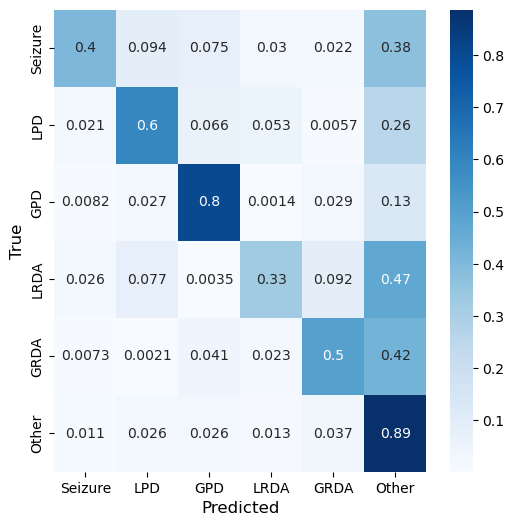

In [22]:
plot_oof = oof_df.copy()

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(plot_oof['target_id'], plot_oof['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.show()

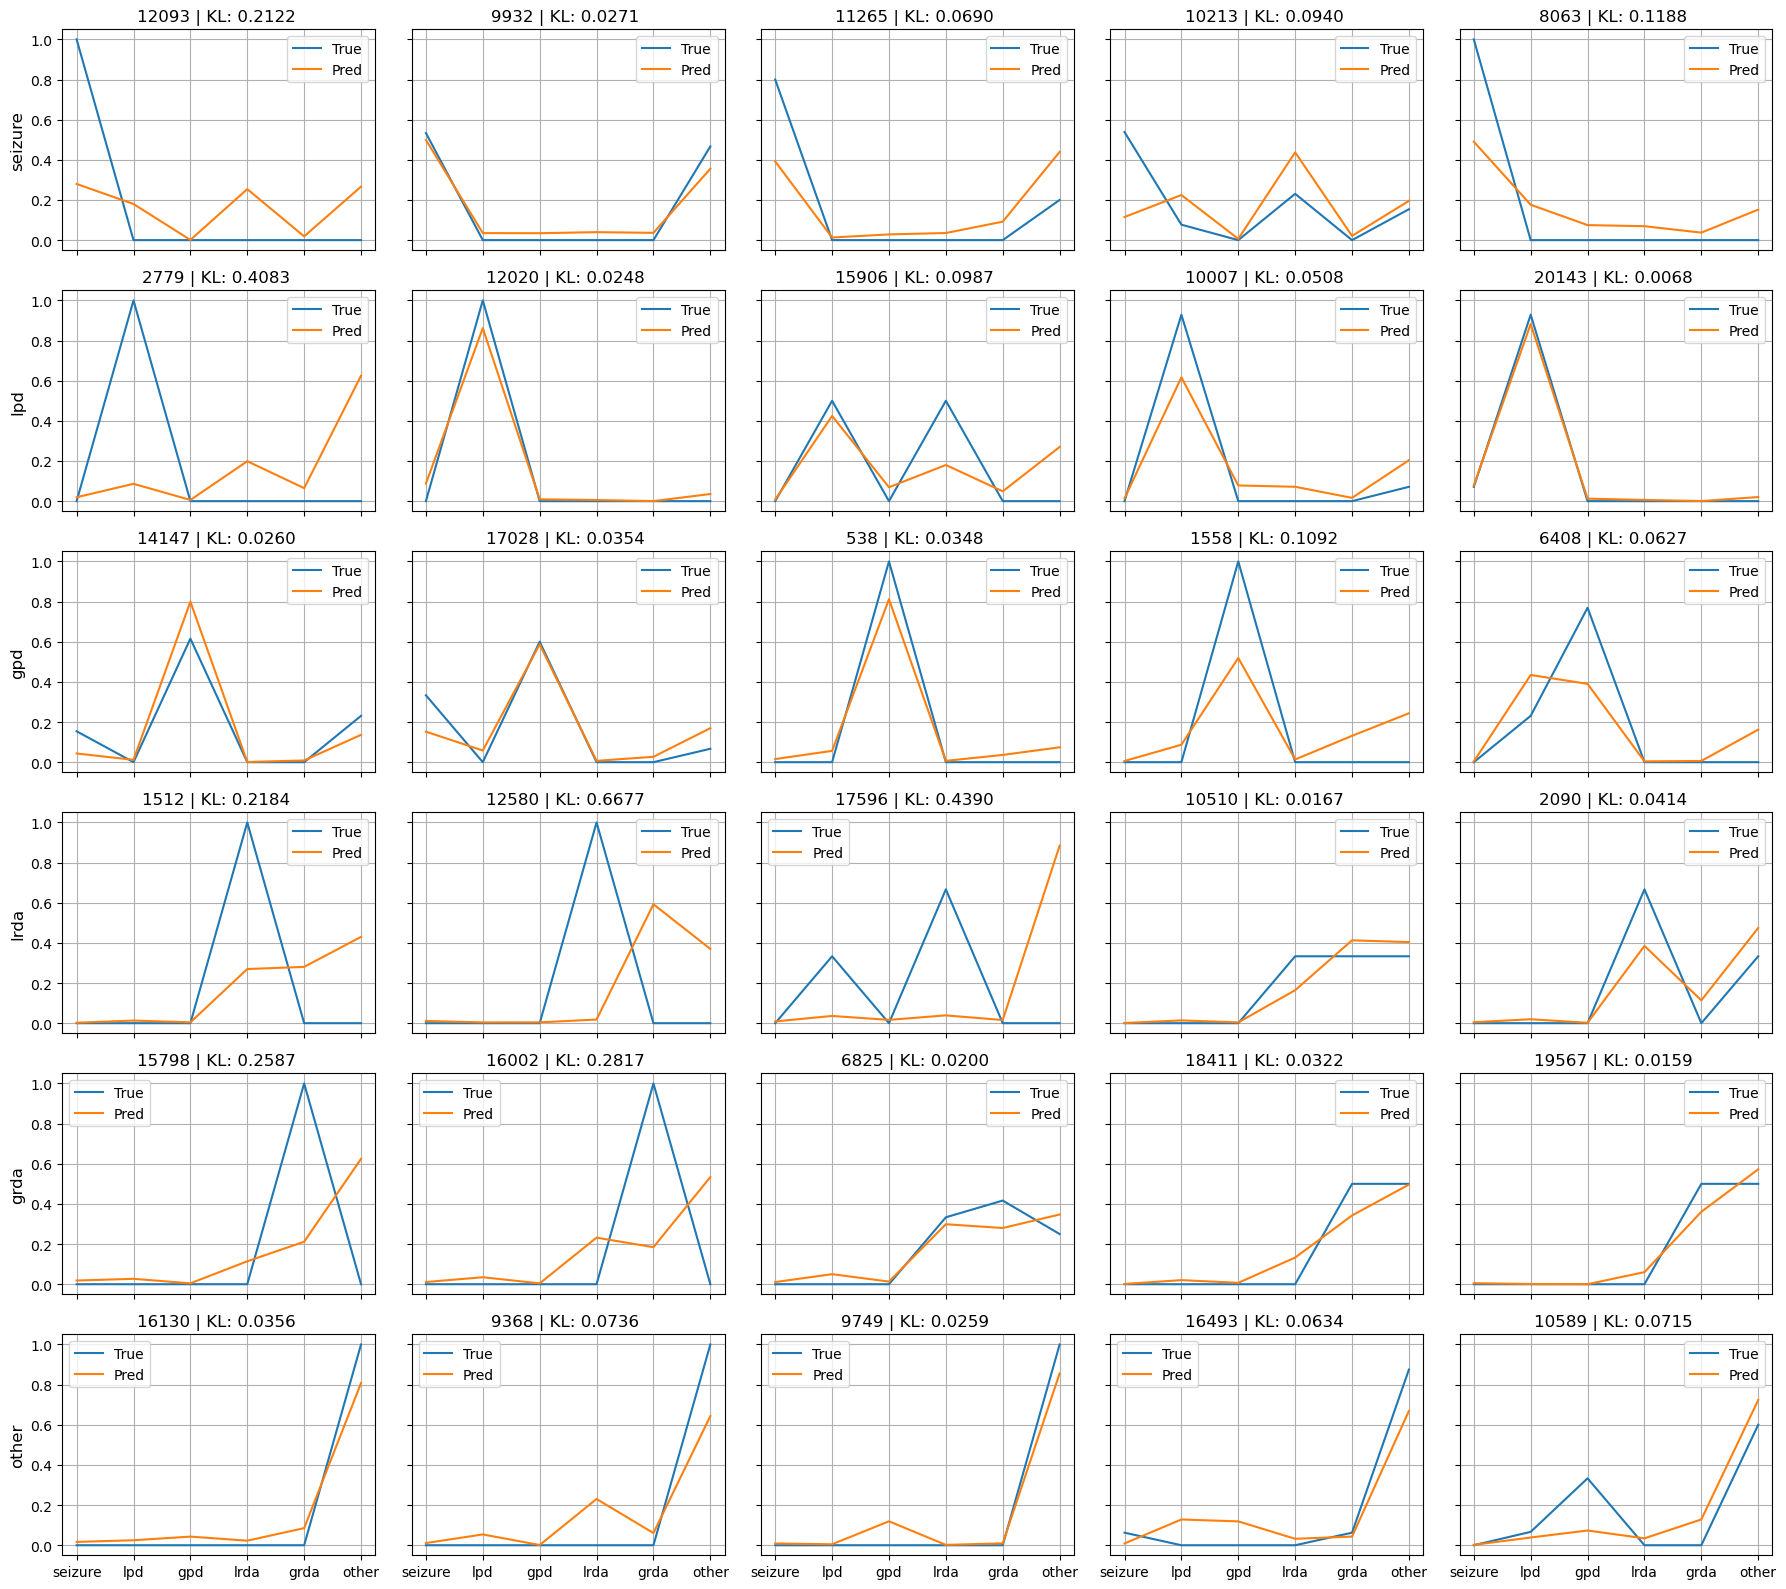

In [23]:
# new figure
fig, axes = plt.subplots(6, 5, figsize=(18, 16), sharex=True, sharey=True)

for row in range(axes.shape[0]):
    row_selects = plot_oof[plot_oof['target_id']==row]
    target_label = BRAIN_ACTIVITY[row]
    for col in range(axes.shape[1]):
        ax = axes[row, col]
        idx = np.random.choice(row_selects.index)
        df_rows = plot_oof.loc[idx]
        ax.plot(df_rows[TARGETS].values , label='True')
        ax.plot(df_rows[TARGETS_PRED].values, label='Pred')
        ax.set_title(f"{idx} | KL: {df_rows['kl_loss']:.4f} ") #
        ax.set_xticks(range(6))
        ax.set_xticklabels(BRAIN_ACTIVITY)
        ax.grid(True)
        ax.legend()
        if col == 0:
            ax.set_ylabel(target_label, fontsize=12)
       
fig.tight_layout()
plt.show()

In [24]:
oof_df = pd.read_csv("./outputs/ENet_b2_xymasking_regularized_005/ENet_b2_xymasking_regularized_oof_2.csv")
y_pred = oof_df[TARGETS].values.astype(np.float32)
y_pred_smax = SOFTMAX(torch.tensor(y_pred)).numpy()
oof_df[TARGETS_PRED] = y_pred_smax
oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
oof_df['target_id'] = oof_df['target'].map(TARGET2ID)
oof_df.head()

,eeg_id,spectrogram_id,min,max,patient_id,target,total_votes,entropy,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,fold,easy_or_hard,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id
0,778705,52296320,0.0,0.0,40955,Other,2,7.686820,0.0,0.0,0.0,0.0,0.0,1.0,0.0,easy,0.129563,0.129563,0.129563,0.129563,0.129563,0.352187,5,5
1,4559645,1902315832,2436.0,2436.0,22195,GRDA,1,7.802343,0.0,0.0,0.0,0.0,1.0,0.0,0.0,easy,0.129563,0.129563,0.129563,0.129563,0.352187,0.129563,4,4
2,9980241,437709580,0.0,72.0,36557,Seizure,21,7.619243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,easy,0.352187,0.129563,0.129563,0.129563,0.129563,0.129563,0,0
3,10249311,498849051,0.0,0.0,47284,Other,1,7.802343,0.0,0.0,0.0,0.0,0.0,1.0,0.0,easy,0.129563,0.129563,0.129563,0.129563,0.129563,0.352187,5,5
4,19529277,122348896,0.0,82.0,49187,Seizure,57,7.619243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,easy,0.352187,0.129563,0.129563,0.129563,0.129563,0.129563,0,0


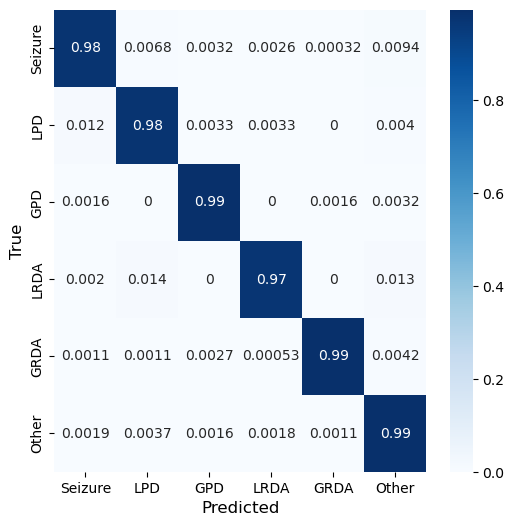

In [25]:
plot_oof = oof_df.copy()

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(plot_oof['target_id'], plot_oof['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.show()

In [ ]:
from scipy.special import softmax

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

oof_df = pd.read_csv("./outputs/ENet_b2_xymasking_remove_less/ENet_b2_xymasking_remove_less_oof_2.csv")
display_rows = oof_df[TARGETS].nunique(axis=1)>2

oof_df[TARGETS] = softmax( oof_df[TARGETS].astype(np.float32), axis=1)
display(oof_df.head(10))

display(oof_df[oof_df['eeg_id'] == 4279600028])

# plot_idx = 20163 #np.random.choice(oof_df[display_rows].index, 1)                 
# y_pred = oof_df[TARGETS].values.astype(np.float32)

# print(plot_idx, oof_df.loc[plot_idx][TARGETS].values)

# y_pred_smax = SOFTMAX(torch.tensor(y_pred)).numpy()
# oof_df[TARGETS_PRED] = y_pred_smax
# axes[0].plot(oof_df.loc[plot_idx][TARGETS].values, label='True')
# axes[0].plot(oof_df.loc[plot_idx][TARGETS_PRED].values , label='Pred')
# print(f"Softmax pred: {oof_df.loc[plot_idx][TARGETS_PRED].values }")

# y_pred_new = (y_pred - y_pred.min(axis=1)[:, np.newaxis]) / (y_pred.max(axis=1)[:, np.newaxis] - y_pred.min(axis=1)[:, np.newaxis])
# y_pred_norm = y_pred_new / y_pred_new.sum(axis=1)[:, np.newaxis]
# oof_df[TARGETS_PRED] = y_pred_norm
# axes[1].plot(oof_df.loc[plot_idx][TARGETS].values , label='True')
# axes[1].plot(oof_df.loc[plot_idx][TARGETS_PRED].values , label='Pred')
# print(f"Normalized pred: {oof_df.loc[plot_idx][TARGETS_PRED].values }")


# for ax in axes:
#     ax.legend()
#     ax.grid(True)

# plt.show()




In [ ]:
oof_df[oof_df['eeg_id'] == 11127485]

In [ ]:
oof_df[oof_df['eeg_id'].duplicated()] #oof_df.shape #.groupby('eeg_id')['patient_id'].agg(['nunique', 'count']).sort_values(by='count', ascending=False).head(10)

In [ ]:
score_kaggle = oof_df2.loc[:10].apply(lambda row: calc_kaggle_score(row[['eeg_id']+TARGETS], row[['eeg_id']+TARGETS_PRED]), axis=1)
score_kaggle

In [ ]:
submission_df = oof_df2[['eeg_id']+TARGETS_PRED].copy()
submission_df.columns = ['eeg_id'] + TARGETS

solution_df = oof_df2[['eeg_id']+TARGETS].copy()

score_value = kaggle_score(solution_df, submission_df, 'eeg_id')

score_value

In [ ]:
# oof_df1, cv_1 = analyze_oof("./outputs/ENet_b2_xymasking_remove_less/ENet_b2_xymasking_remove_less_oof_1.csv")
# print(cv_1)
# oof_df1.head()